<a href="https://colab.research.google.com/github/mrlocastellani/pamap2/blob/main/pamap2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from google.colab import drive
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,RobustScaler
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, GRU
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder

In [5]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
list_of_files = [r"/content/drive/MyDrive/ColabData/Protocol/subject101.dat",
                 r"/content/drive/MyDrive/ColabData/Protocol/subject102.dat",
                 r"/content/drive/MyDrive/ColabData/Protocol/subject103.dat",
                 r"/content/drive/MyDrive/ColabData/Protocol/subject104.dat",
                 r"/content/drive/MyDrive/ColabData/Protocol/subject105.dat",
                 r"/content/drive/MyDrive/ColabData/Protocol/subject106.dat",
                 r"/content/drive/MyDrive/ColabData/Protocol/subject107.dat",
                 r"/content/drive/MyDrive/ColabData/Protocol/subject108.dat",
                 r"/content/drive/MyDrive/ColabData/Protocol/subject109.dat"]

subjectID = [1,2,3,4,5,6,7,8,9]

activityIDdict = {0: 'transient',
                  1: 'lying',
                  2: 'sitting',
                  3: 'standing',
                  4: 'walking',
                  5: 'running',
                  6: 'cycling',
                  7: 'Nordic_walking',
                  9: 'watching_TV',
                  10: 'computer_work',
                  11: 'car driving',
                  12: 'ascending_stairs',
                  13: 'descending_stairs',
                  16: 'vacuum_cleaning',
                  17: 'ironing',
                  18: 'folding_laundry',
                  19: 'house_cleaning',
                  20: 'playing_soccer',
                  24: 'rope_jumping' }

colNames = ["timestamp", "activityID","heartrate"]

IMUhand = ['handTemperature',
           'handAcc16_1', 'handAcc16_2', 'handAcc16_3',
           'handAcc6_1', 'handAcc6_2', 'handAcc6_3',
           'handGyro1', 'handGyro2', 'handGyro3',
           'handMagne1', 'handMagne2', 'handMagne3',
           'handOrientation1', 'handOrientation2', 'handOrientation3', 'handOrientation4']

IMUchest = ['chestTemperature',
            'chestAcc16_1', 'chestAcc16_2', 'chestAcc16_3',
            'chestAcc6_1', 'chestAcc6_2', 'chestAcc6_3',
            'chestGyro1', 'chestGyro2', 'chestGyro3',
            'chestMagne1', 'chestMagne2', 'chestMagne3',
            'chestOrientation1', 'chestOrientation2', 'chestOrientation3', 'chestOrientation4']

IMUankle = ['ankleTemperature',
            'ankleAcc16_1', 'ankleAcc16_2', 'ankleAcc16_3',
            'ankleAcc6_1', 'ankleAcc6_2', 'ankleAcc6_3',
            'ankleGyro1', 'ankleGyro2', 'ankleGyro3',
            'ankleMagne1', 'ankleMagne2', 'ankleMagne3',
            'ankleOrientation1', 'ankleOrientation2', 'ankleOrientation3', 'ankleOrientation4']

columns = colNames + IMUhand + IMUchest + IMUankle  #all columns in one list

len(columns)

54

In [ ]:
dataCollection = pd.DataFrame()
for file in list_of_files:
    procData = pd.read_table(file, header=None, sep='\s+')
    procData.columns = columns
    procData['subject_id'] = int(file[-5])
    dataCollection = pd.concat([dataCollection, procData], ignore_index=True)

dataCollection.reset_index(drop=True, inplace=True)
dataCollection.head()

In [ ]:
def dataCleaning(dataCollection):
        dataCollection = dataCollection.drop(['handOrientation1', 'handOrientation2', 'handOrientation3', 'handOrientation4',
                                             'chestOrientation1', 'chestOrientation2', 'chestOrientation3', 'chestOrientation4',
                                             'ankleOrientation1', 'ankleOrientation2', 'ankleOrientation3', 'ankleOrientation4'],
                                             axis = 1)  # removal of orientation columns according to the readme
        dataCollection = dataCollection.drop(dataCollection[dataCollection.activityID == 0].index) #removal of any row of activity 0 as it is transient activity which it is not used
        dataCollection = dataCollection.apply(pd.to_numeric, errors = 'coerce') #removal of non numeric data in cells
        dataCollection = dataCollection.interpolate() #removal of any remaining NaN value cells by constructing new data points in known set of data points

        return dataCollection

In [ ]:
dataCol = dataCleaning(dataCollection)
dataCol.reset_index(drop = True, inplace = True)
dataCol.head(10)

In [ ]:
for i in range(0, 4):
    dataCol.loc[:3, "heartrate"] = 100

In [ ]:
dataCol.to_csv('pamap_data_collection.csv', index=False)

In [ ]:
dataCol

In [ ]:
dataCol.to_csv('/content/drive/MyDrive/ColabData/pamap_data_collection.csv', index=False)

In [ ]:
dataCol.head()

In [6]:
dataCollection = pd.read_csv('/content/drive/MyDrive/ColabData/pamap_data_collection.csv')
print(dataCollection)

         timestamp  activityID  heartrate  handTemperature  handAcc16_1  \
0            37.66           1      100.0           30.375      2.21530   
1            37.67           1      100.0           30.375      2.29196   
2            37.68           1      100.0           30.375      2.29090   
3            37.69           1      100.0           30.375      2.21800   
4            37.70           1      100.0           30.375      2.30106   
...            ...         ...        ...              ...          ...   
1942867      95.06          24      162.0           25.125      4.99466   
1942868      95.07          24      162.0           25.125      5.02764   
1942869      95.08          24      162.0           25.125      5.06409   
1942870      95.09          24      162.0           25.125      5.13914   
1942871      95.10          24      162.0           25.125      5.00812   

         handAcc16_2  handAcc16_3  handAcc6_1  handAcc6_2  handAcc6_3  ...  \
0            8.27915 

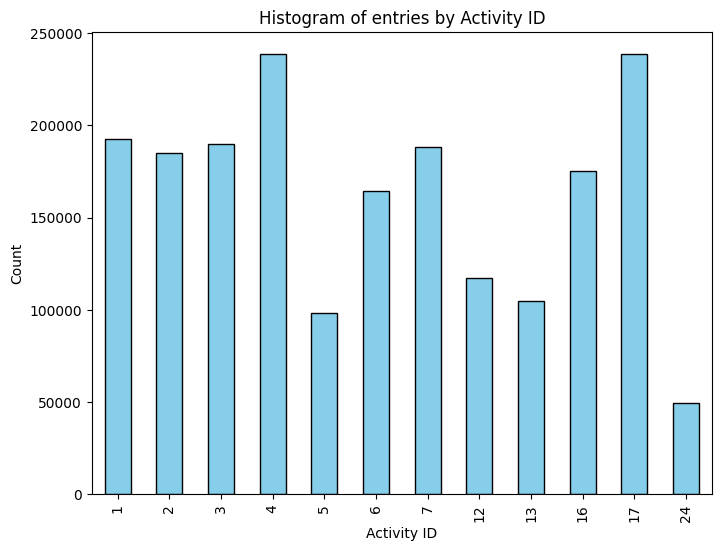

In [7]:
plt.figure(figsize=(8, 6))
dataCollection['activityID'].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Histogram of entries by Activity ID')
plt.xlabel('Activity ID')
plt.ylabel('Count')
plt.show()

In [8]:
dataCollection

,timestamp,activityID,heartrate,handTemperature,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,...,ankleAcc6_1,ankleAcc6_2,ankleAcc6_3,ankleGyro1,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3,subject_id
0,37.66,1,100.0,30.375,2.21530,8.27915,5.58753,2.24689,8.55387,5.77143,...,9.63162,-1.76757,0.265761,0.002908,-0.027714,0.001752,-61.1081,-36.863600,-58.369600,1
1,37.67,1,100.0,30.375,2.29196,7.67288,5.74467,2.27373,8.14592,5.78739,...,9.58649,-1.75247,0.250816,0.020882,0.000945,0.006007,-60.8916,-36.319700,-58.365600,1
2,37.68,1,100.0,30.375,2.29090,7.14240,5.82342,2.26966,7.66268,5.78846,...,9.60196,-1.73721,0.356632,-0.035392,-0.052422,-0.004882,-60.3407,-35.784200,-58.611900,1
3,37.69,1,100.0,30.375,2.21800,7.14365,5.89930,2.22177,7.25535,5.88000,...,9.58674,-1.78264,0.311453,-0.032514,-0.018844,0.026950,-60.7646,-37.102800,-57.879900,1
4,37.70,1,100.0,30.375,2.30106,7.25857,6.09259,2.20720,7.24042,5.95555,...,9.64677,-1.75240,0.295902,0.001351,-0.048878,-0.006328,-60.2040,-37.122500,-57.884700,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1942867,95.06,24,162.0,25.125,4.99466,6.01881,5.59830,4.90787,6.05780,5.68357,...,9.41274,-2.26922,-1.759580,0.021288,-0.012885,0.005878,-45.7855,-0.831734,-0.170139,9
1942868,95.07,24,162.0,25.125,5.02764,5.90369,5.48372,4.89090,5.95209,5.56301,...,9.33733,-2.23908,-1.834950,0.010715,0.003629,-0.004235,-46.0331,-0.817288,0.538134,9
1942869,95.08,24,162.0,25.125,5.06409,5.71370,5.48491,4.97981,5.87584,5.45738,...,9.32243,-2.23905,-1.804610,-0.016939,-0.035176,-0.002309,-45.5140,-1.229410,0.540438,9
1942870,95.09,24,162.0,25.125,5.13914,5.63724,5.48629,4.97690,5.69448,5.29167,...,9.38220,-2.26938,-1.880500,-0.028069,-0.036457,-0.007076,-45.9093,-0.565555,0.680109,9


In [22]:
valid_activity_ids = [1, 2, 3, 4, 16, 17]

data = dataCollection[dataCollection['activityID'].isin(valid_activity_ids)].copy()

label_encoder = LabelEncoder()

data['activityID'] = label_encoder.fit_transform(data['activityID'])

feature_columns = ['heartrate',
 'handTemperature',
 'handAcc16_1',
 'handAcc16_2',
 'handAcc16_3',
 'handAcc6_1',
 'handAcc6_2',
 'handAcc6_3',
 'handGyro1',
 'handGyro2',
 'handGyro3',
 'handMagne1',
 'handMagne2',
 'handMagne3',
 'chestTemperature',
 'chestAcc16_1',
 'chestAcc16_2',
 'chestAcc16_3',
 'chestAcc6_1',
 'chestAcc6_2',
 'chestAcc6_3',
 'chestGyro1',
 'chestGyro2',
 'chestGyro3',
 'chestMagne1',
 'chestMagne2',
 'chestMagne3',
 'ankleTemperature',
 'ankleAcc16_1',
 'ankleAcc16_2',
 'ankleAcc16_3',
 'ankleAcc6_1',
 'ankleAcc6_2',
 'ankleAcc6_3',
 'ankleGyro1',
 'ankleGyro2',
 'ankleGyro3',
 'ankleMagne1',
 'ankleMagne2',
 'ankleMagne3']
label_column = 'activityID'

CÓDIGO CORRENTE A SER TESTADO É O ABAIXO

In [23]:
subjects_to_test = [7, 8]
mask = data['subject_id'].isin(subjects_to_test)

data_to_test = data[mask].copy()
data = data[~mask]

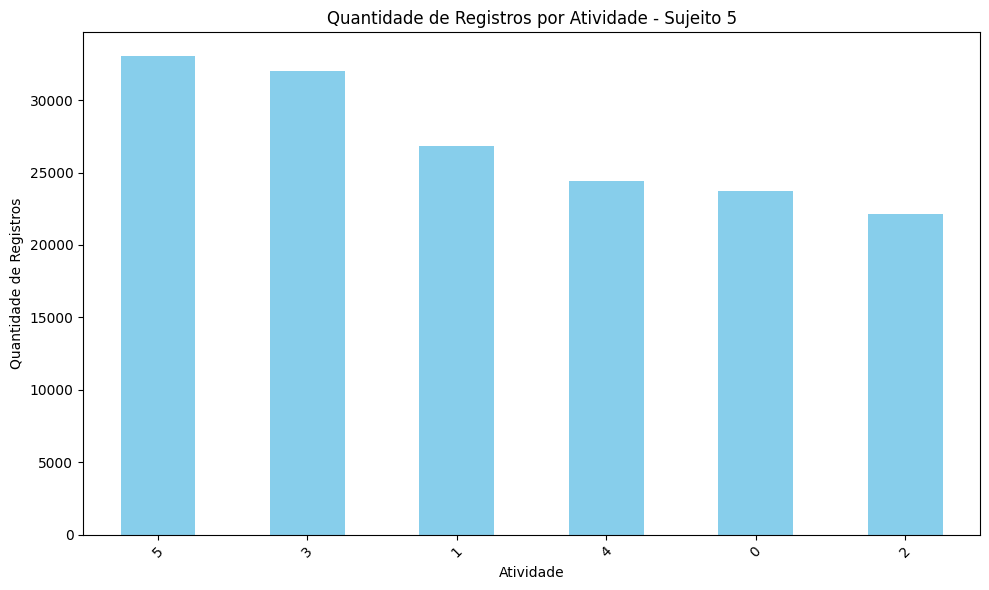

In [24]:
subject_id = 5
subject_data = data[data['subject_id'] == subject_id]

# Contagem de registros por atividade para o sujeito específico
activity_counts = subject_data['activityID'].value_counts()

# Gráfico de barras para mostrar a quantidade de registros por atividade para o sujeito escolhido
plt.figure(figsize=(10, 6))
activity_counts.plot(kind='bar', color='skyblue')
plt.title(f'Quantidade de Registros por Atividade - Sujeito {subject_id}')
plt.xlabel('Atividade')
plt.ylabel('Quantidade de Registros')
plt.xticks(rotation=45)  # Rotaciona os rótulos do eixo x para facilitar a leitura
plt.tight_layout()
plt.show()

No data leakage detected.
Epoch 1/8
2880/2880 [==============================] - 19s 5ms/step - loss: 0.6619 - accuracy: 0.9876 - val_loss: 0.0943 - val_accuracy: 0.9999
Epoch 2/8
2880/2880 [==============================] - 14s 5ms/step - loss: 0.1253 - accuracy: 0.9999 - val_loss: 0.0260 - val_accuracy: 1.0000
Epoch 3/8
2880/2880 [==============================] - 14s 5ms/step - loss: 0.0199 - accuracy: 0.9999 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 4/8
2880/2880 [==============================] - 18s 6ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 4.8690e-04 - val_accuracy: 1.0000
Epoch 5/8
2880/2880 [==============================] - 15s 5ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 6/8
2880/2880 [==============================] - 12s 4ms/step - loss: 3.1059e-04 - accuracy: 1.0000 - val_loss: 4.4322e-04 - val_accuracy: 1.0000
Epoch 7/8
2880/2880 [==============================] - 14s 5ms/step - loss: 5.1547e-04 - accuracy:

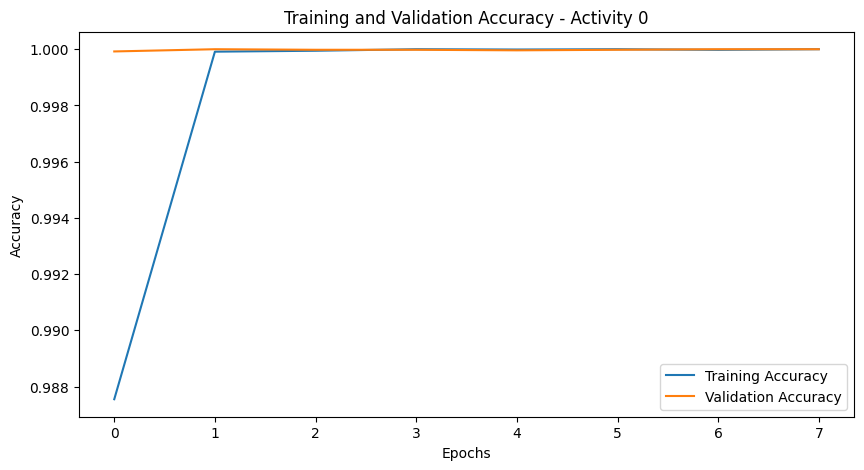

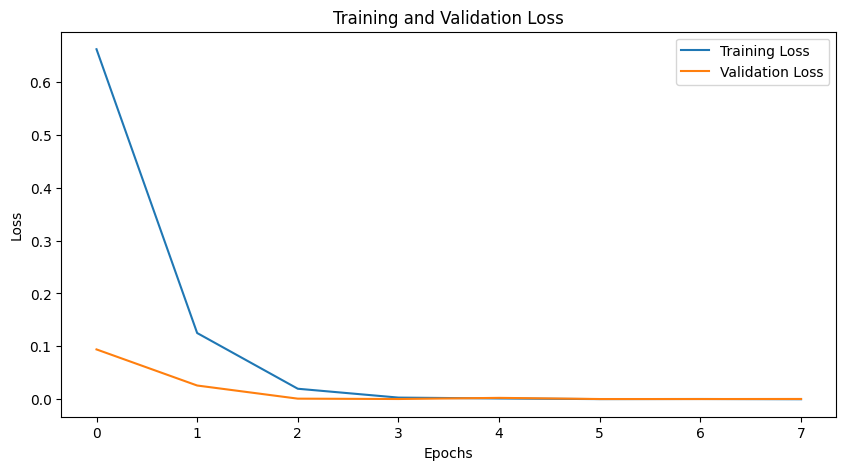

Epoch 1/8
3255/3255 [==============================] - 26s 6ms/step - loss: 0.3174 - accuracy: 0.8737 - val_loss: 0.1216 - val_accuracy: 0.9526
Epoch 2/8
3255/3255 [==============================] - 14s 4ms/step - loss: 0.0218 - accuracy: 0.9880 - val_loss: 0.0098 - val_accuracy: 0.9947
Epoch 3/8
3255/3255 [==============================] - 14s 4ms/step - loss: 0.0032 - accuracy: 0.9984 - val_loss: 0.0054 - val_accuracy: 0.9970
Epoch 4/8
3255/3255 [==============================] - 16s 5ms/step - loss: 0.0076 - accuracy: 0.9958 - val_loss: 0.0039 - val_accuracy: 0.9980
Epoch 5/8
3255/3255 [==============================] - 15s 5ms/step - loss: 0.0011 - accuracy: 0.9995 - val_loss: 0.0049 - val_accuracy: 0.9982
Epoch 6/8
3255/3255 [==============================] - 16s 5ms/step - loss: 3.4823e-04 - accuracy: 0.9998 - val_loss: 0.0043 - val_accuracy: 0.9978
Epoch 7/8
3255/3255 [==============================] - 16s 5ms/step - loss: 1.9231e-04 - accuracy: 0.9999 - val_loss: 0.0039 - val_a

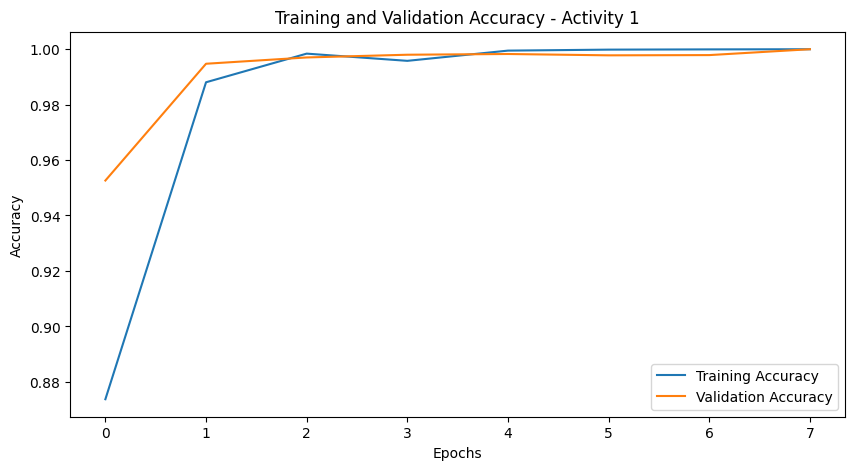

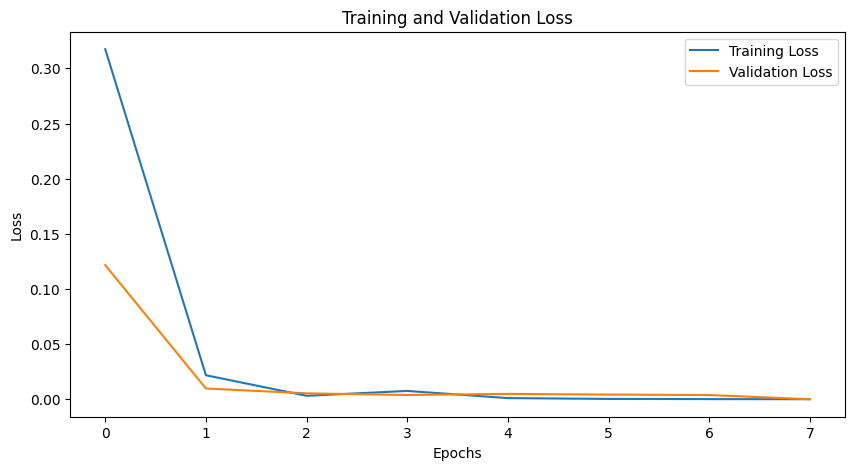

Epoch 1/8
2867/2867 [==============================] - 15s 5ms/step - loss: 0.3190 - accuracy: 0.8907 - val_loss: 0.3449 - val_accuracy: 0.8091
Epoch 2/8
2867/2867 [==============================] - 14s 5ms/step - loss: 0.0230 - accuracy: 0.9876 - val_loss: 0.2725 - val_accuracy: 0.8479
Epoch 3/8
2867/2867 [==============================] - 14s 5ms/step - loss: 0.0573 - accuracy: 0.9692 - val_loss: 0.5434 - val_accuracy: 0.6970
Epoch 4/8
2867/2867 [==============================] - 14s 5ms/step - loss: 0.0787 - accuracy: 0.9565 - val_loss: 1.2511 - val_accuracy: 0.3051
Epoch 5/8
2867/2867 [==============================] - 14s 5ms/step - loss: 0.0619 - accuracy: 0.9657 - val_loss: 1.1839 - val_accuracy: 0.3420
Epoch 6/8
2867/2867 [==============================] - 15s 5ms/step - loss: 0.0458 - accuracy: 0.9745 - val_loss: 1.3086 - val_accuracy: 0.2700
Epoch 7/8
2867/2867 [==============================] - 12s 4ms/step - loss: 0.0339 - accuracy: 0.9811 - val_loss: 0.7068 - val_accuracy:

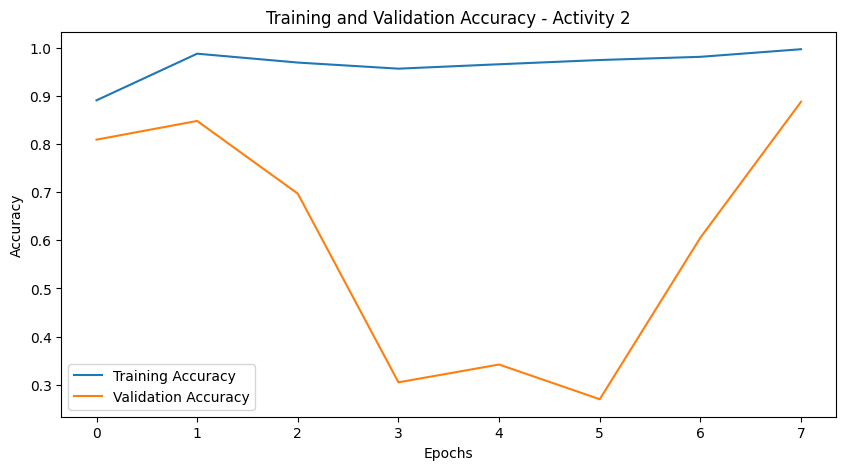

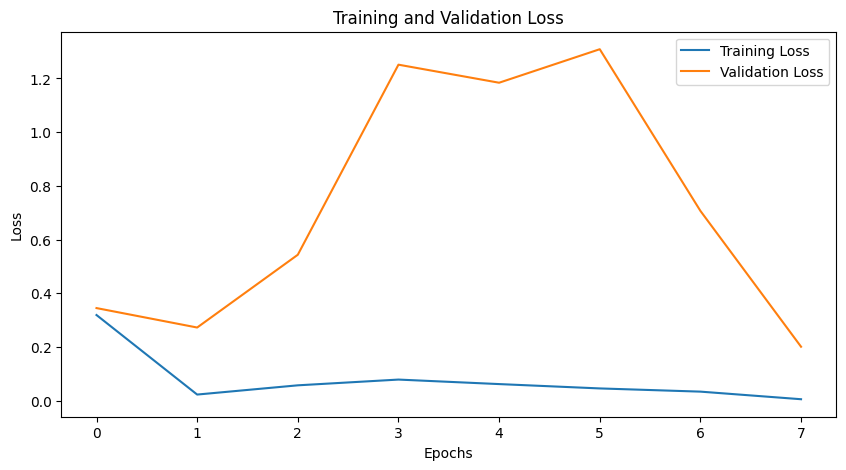

Epoch 1/8
3868/3868 [==============================] - 19s 4ms/step - loss: 0.2780 - accuracy: 0.9082 - val_loss: 0.2328 - val_accuracy: 0.8701
Epoch 2/8
3868/3868 [==============================] - 16s 4ms/step - loss: 0.0119 - accuracy: 0.9937 - val_loss: 0.0159 - val_accuracy: 0.9911
Epoch 3/8
3868/3868 [==============================] - 19s 5ms/step - loss: 0.0014 - accuracy: 0.9992 - val_loss: 0.0038 - val_accuracy: 0.9979
Epoch 4/8
3868/3868 [==============================] - 20s 5ms/step - loss: 3.9342e-04 - accuracy: 0.9998 - val_loss: 2.0562e-04 - val_accuracy: 0.9999
Epoch 5/8
3868/3868 [==============================] - 23s 6ms/step - loss: 3.4811e-04 - accuracy: 0.9998 - val_loss: 3.4725e-05 - val_accuracy: 1.0000
Epoch 6/8
3868/3868 [==============================] - 23s 6ms/step - loss: 5.9483e-05 - accuracy: 1.0000 - val_loss: 5.4276e-07 - val_accuracy: 1.0000
Epoch 7/8
3868/3868 [==============================] - 19s 5ms/step - loss: 1.4966e-05 - accuracy: 1.0000 - val_

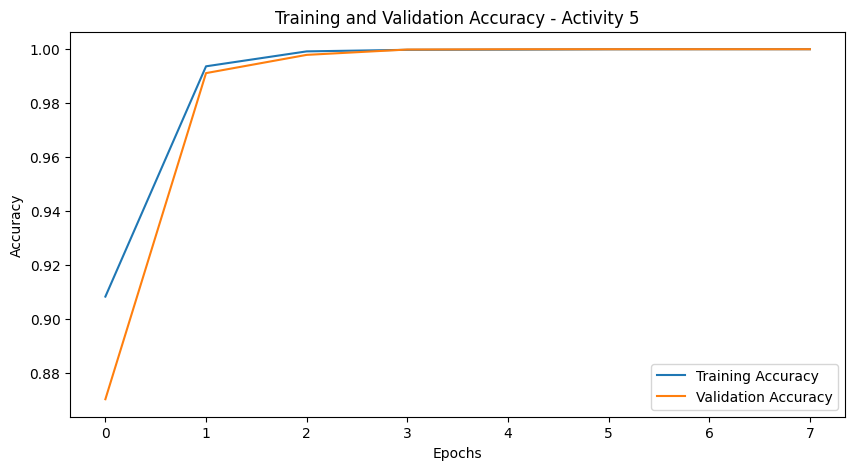

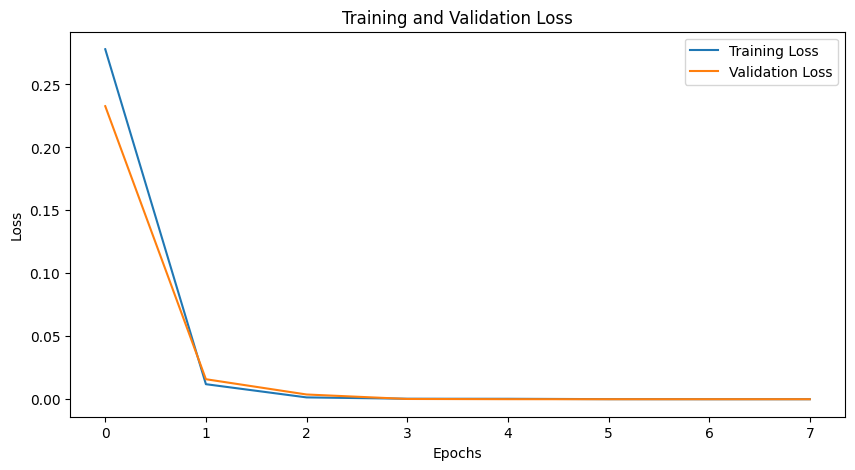

Epoch 1/8
2684/2684 [==============================] - 18s 6ms/step - loss: 0.4255 - accuracy: 0.8926 - val_loss: 0.0252 - val_accuracy: 0.9865
Epoch 2/8
2684/2684 [==============================] - 15s 6ms/step - loss: 0.0684 - accuracy: 0.9638 - val_loss: 0.0188 - val_accuracy: 0.9896
Epoch 3/8
2684/2684 [==============================] - 15s 6ms/step - loss: 0.0565 - accuracy: 0.9693 - val_loss: 0.0453 - val_accuracy: 0.9749
Epoch 4/8
2684/2684 [==============================] - 15s 6ms/step - loss: 0.0570 - accuracy: 0.9686 - val_loss: 0.0257 - val_accuracy: 0.9857
Epoch 5/8
2684/2684 [==============================] - 17s 6ms/step - loss: 0.0271 - accuracy: 0.9852 - val_loss: 0.0115 - val_accuracy: 0.9936
Epoch 6/8
2684/2684 [==============================] - 16s 6ms/step - loss: 0.0141 - accuracy: 0.9923 - val_loss: 0.0092 - val_accuracy: 0.9948
Epoch 7/8
2684/2684 [==============================] - 14s 5ms/step - loss: 0.0096 - accuracy: 0.9946 - val_loss: 0.0047 - val_accuracy:

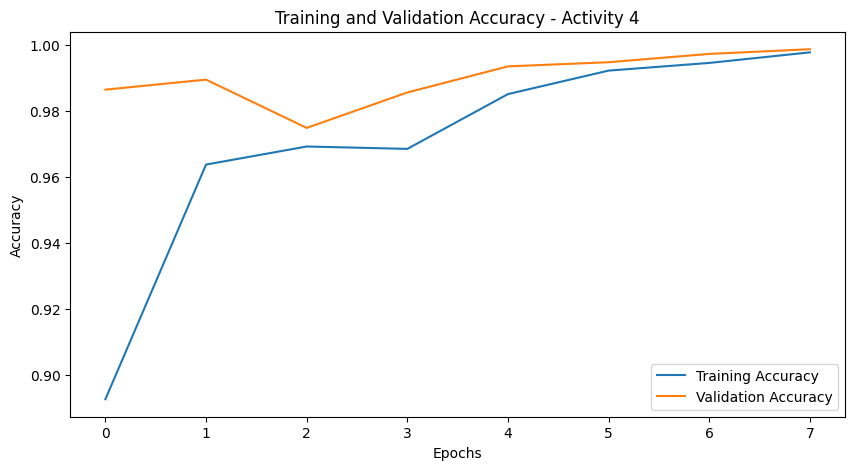

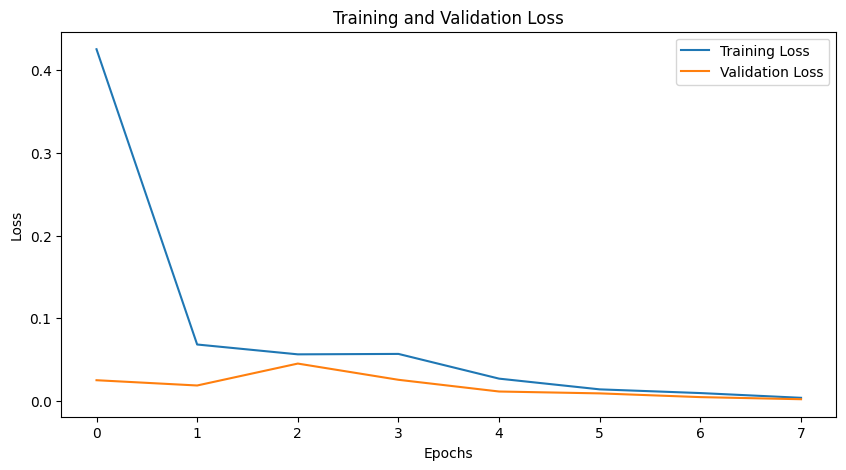

Epoch 1/8
3711/3711 [==============================] - 25s 6ms/step - loss: 0.3079 - accuracy: 0.8712 - val_loss: 0.0285 - val_accuracy: 0.9841
Epoch 2/8
3711/3711 [==============================] - 19s 5ms/step - loss: 0.0261 - accuracy: 0.9855 - val_loss: 2.1187e-05 - val_accuracy: 1.0000
Epoch 3/8
3711/3711 [==============================] - 20s 5ms/step - loss: 5.6945e-04 - accuracy: 0.9997 - val_loss: 0.0018 - val_accuracy: 0.9996
Epoch 4/8
3711/3711 [==============================] - 21s 6ms/step - loss: 0.0034 - accuracy: 0.9982 - val_loss: 0.0031 - val_accuracy: 0.9983
Epoch 5/8
3711/3711 [==============================] - 19s 5ms/step - loss: 9.3719e-04 - accuracy: 0.9995 - val_loss: 5.2390e-04 - val_accuracy: 0.9997
Epoch 6/8
3711/3711 [==============================] - 20s 5ms/step - loss: 1.8331e-04 - accuracy: 0.9999 - val_loss: 2.2953e-04 - val_accuracy: 0.9999
Epoch 7/8
3711/3711 [==============================] - 20s 6ms/step - loss: 1.7373e-06 - accuracy: 1.0000 - val_

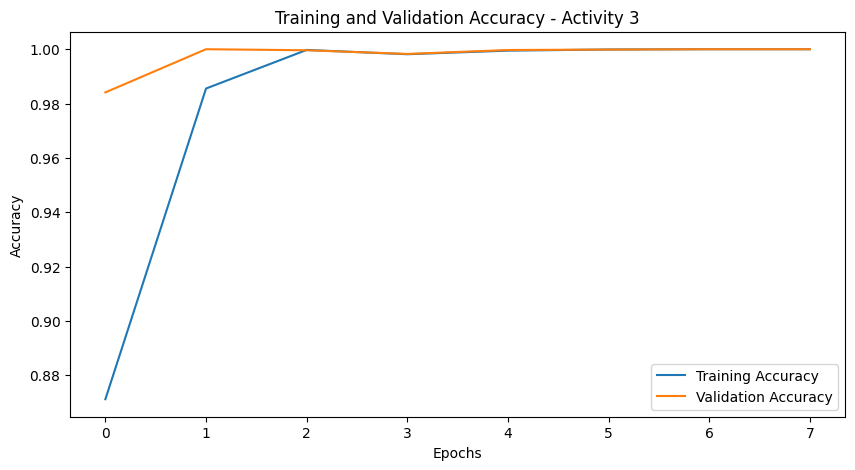

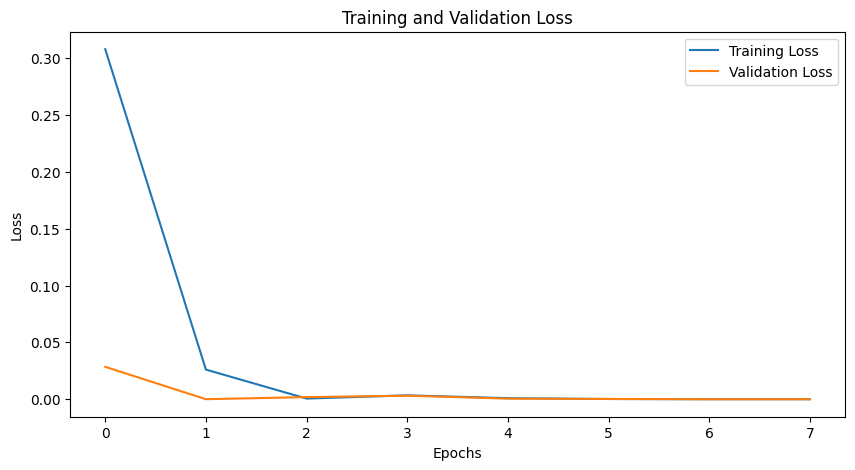

No data leakage detected.
Epoch 1/8
3732/3732 [==============================] - 18s 4ms/step - loss: 0.2401 - accuracy: 0.9916 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 2/8
3732/3732 [==============================] - 16s 4ms/step - loss: 0.0042 - accuracy: 0.9999 - val_loss: 0.0024 - val_accuracy: 1.0000
Epoch 3/8
3732/3732 [==============================] - 16s 4ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 4/8
3732/3732 [==============================] - 19s 5ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 7.3974e-04 - val_accuracy: 1.0000
Epoch 5/8
3732/3732 [==============================] - 18s 5ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 3.0767e-04 - val_accuracy: 1.0000
Epoch 6/8
3732/3732 [==============================] - 19s 5ms/step - loss: 1.8127e-04 - accuracy: 1.0000 - val_loss: 7.7367e-05 - val_accuracy: 1.0000
Epoch 7/8
3732/3732 [==============================] - 18s 5ms/step - loss: 1.0602e-04 - accur

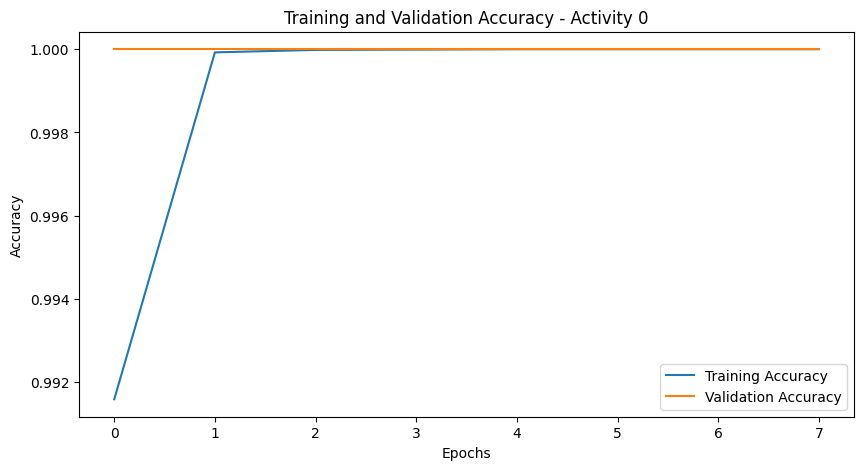

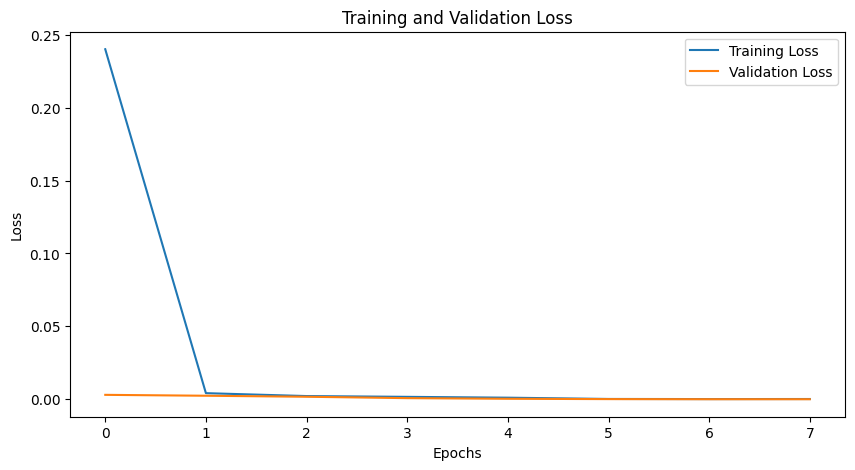

Epoch 1/8
3967/3967 [==============================] - 22s 5ms/step - loss: 0.1581 - accuracy: 0.9534 - val_loss: 0.0071 - val_accuracy: 0.9961
Epoch 2/8
3967/3967 [==============================] - 17s 4ms/step - loss: 0.0082 - accuracy: 0.9958 - val_loss: 0.0064 - val_accuracy: 0.9966
Epoch 3/8
3967/3967 [==============================] - 17s 4ms/step - loss: 0.0046 - accuracy: 0.9974 - val_loss: 0.0016 - val_accuracy: 0.9991
Epoch 4/8
3967/3967 [==============================] - 19s 5ms/step - loss: 0.0016 - accuracy: 0.9992 - val_loss: 1.5492e-06 - val_accuracy: 1.0000
Epoch 5/8
3967/3967 [==============================] - 15s 4ms/step - loss: 5.1045e-06 - accuracy: 1.0000 - val_loss: 5.9612e-07 - val_accuracy: 1.0000
Epoch 6/8
3967/3967 [==============================] - 16s 4ms/step - loss: 3.9247e-06 - accuracy: 1.0000 - val_loss: 5.9605e-07 - val_accuracy: 1.0000
Epoch 7/8
3967/3967 [==============================] - 17s 4ms/step - loss: 1.9505e-06 - accuracy: 1.0000 - val_loss

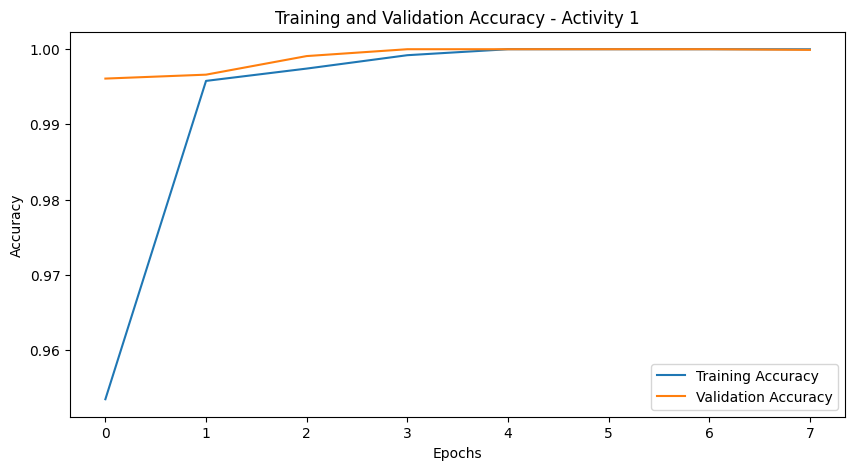

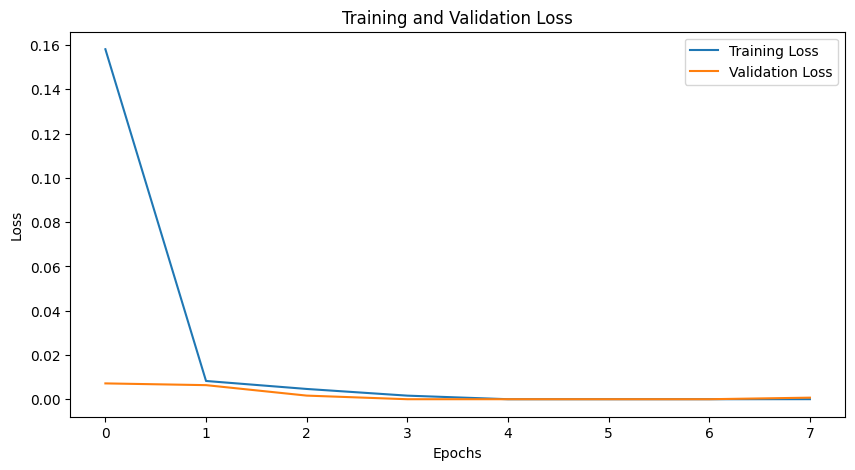

Epoch 1/8
3584/3584 [==============================] - 17s 4ms/step - loss: 0.2033 - accuracy: 0.9277 - val_loss: 0.0176 - val_accuracy: 0.9902
Epoch 2/8
3584/3584 [==============================] - 15s 4ms/step - loss: 0.0942 - accuracy: 0.9486 - val_loss: 0.0152 - val_accuracy: 0.9915
Epoch 3/8
3584/3584 [==============================] - 17s 5ms/step - loss: 0.1112 - accuracy: 0.9385 - val_loss: 0.0823 - val_accuracy: 0.9541
Epoch 4/8
3584/3584 [==============================] - 15s 4ms/step - loss: 0.0927 - accuracy: 0.9485 - val_loss: 0.0441 - val_accuracy: 0.9754
Epoch 5/8
3584/3584 [==============================] - 15s 4ms/step - loss: 0.0436 - accuracy: 0.9757 - val_loss: 0.0135 - val_accuracy: 0.9925
Epoch 6/8
3584/3584 [==============================] - 15s 4ms/step - loss: 0.0096 - accuracy: 0.9947 - val_loss: 0.0090 - val_accuracy: 0.9950
Epoch 7/8
3584/3584 [==============================] - 15s 4ms/step - loss: 0.0047 - accuracy: 0.9974 - val_loss: 0.0025 - val_accuracy:

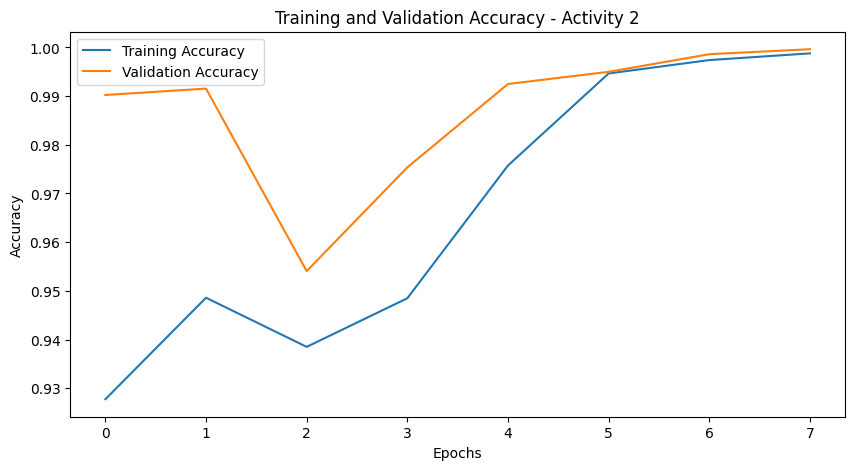

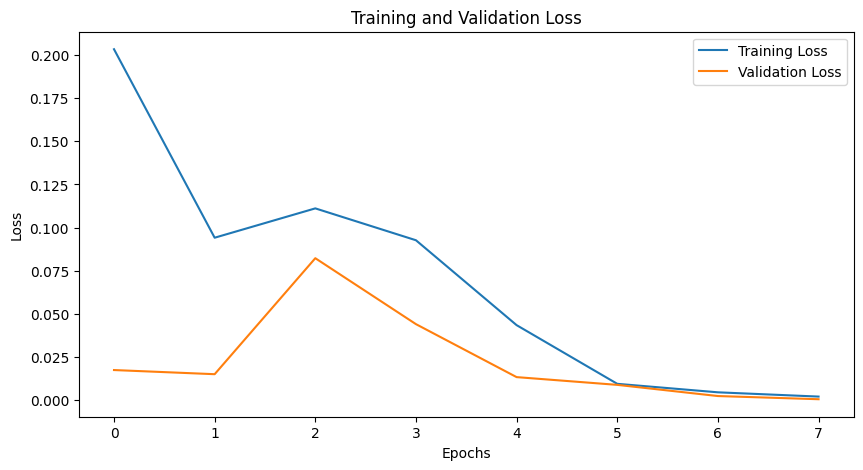

Epoch 1/8
4327/4327 [==============================] - 21s 4ms/step - loss: 0.2432 - accuracy: 0.9242 - val_loss: 0.0076 - val_accuracy: 0.9959
Epoch 2/8
4327/4327 [==============================] - 18s 4ms/step - loss: 0.0270 - accuracy: 0.9852 - val_loss: 0.0016 - val_accuracy: 0.9991
Epoch 3/8
4327/4327 [==============================] - 19s 4ms/step - loss: 0.0082 - accuracy: 0.9954 - val_loss: 0.0011 - val_accuracy: 0.9994
Epoch 4/8
4327/4327 [==============================] - 18s 4ms/step - loss: 0.0023 - accuracy: 0.9987 - val_loss: 1.9040e-04 - val_accuracy: 0.9999
Epoch 5/8
4327/4327 [==============================] - 19s 4ms/step - loss: 5.4896e-04 - accuracy: 0.9997 - val_loss: 4.7897e-07 - val_accuracy: 1.0000
Epoch 6/8
4327/4327 [==============================] - 19s 4ms/step - loss: 2.0869e-04 - accuracy: 0.9999 - val_loss: 4.7845e-07 - val_accuracy: 1.0000
Epoch 7/8
4327/4327 [==============================] - 23s 5ms/step - loss: 3.3431e-04 - accuracy: 0.9998 - val_loss

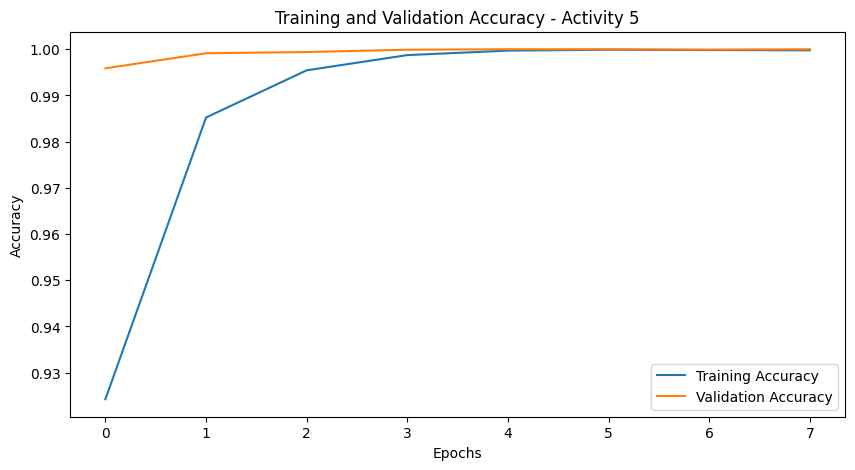

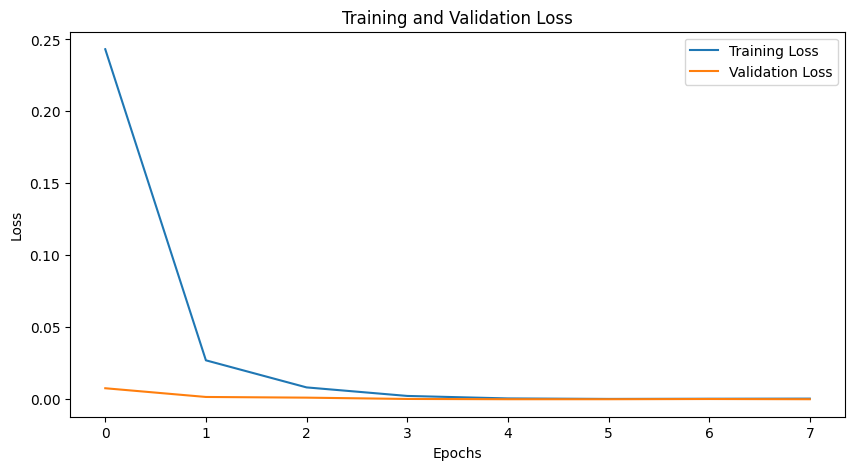

Epoch 1/8
3389/3389 [==============================] - 17s 4ms/step - loss: 0.2655 - accuracy: 0.9331 - val_loss: 0.0178 - val_accuracy: 0.9901
Epoch 2/8
3389/3389 [==============================] - 13s 4ms/step - loss: 0.0347 - accuracy: 0.9813 - val_loss: 0.0040 - val_accuracy: 0.9978
Epoch 3/8
3389/3389 [==============================] - 14s 4ms/step - loss: 0.0062 - accuracy: 0.9968 - val_loss: 2.6112e-04 - val_accuracy: 0.9999
Epoch 4/8
3389/3389 [==============================] - 14s 4ms/step - loss: 0.0024 - accuracy: 0.9987 - val_loss: 2.6935e-04 - val_accuracy: 0.9999
Epoch 5/8
3389/3389 [==============================] - 15s 4ms/step - loss: 0.0012 - accuracy: 0.9994 - val_loss: 2.8349e-04 - val_accuracy: 0.9999
Epoch 6/8
3389/3389 [==============================] - 17s 5ms/step - loss: 6.2502e-04 - accuracy: 0.9997 - val_loss: 4.7877e-07 - val_accuracy: 1.0000
Epoch 7/8
3389/3389 [==============================] - 17s 5ms/step - loss: 1.0006e-04 - accuracy: 0.9999 - val_loss

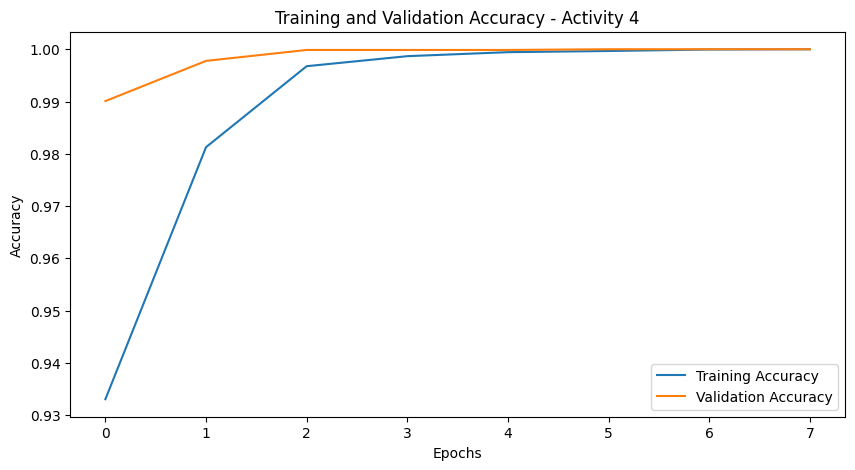

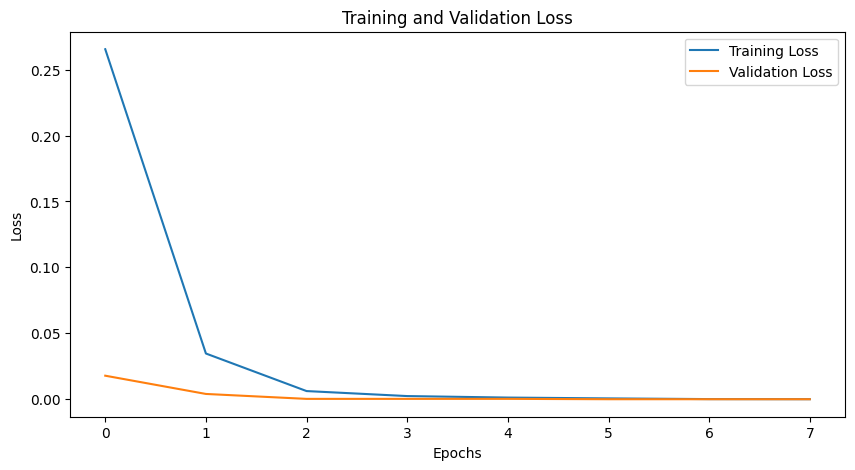

Epoch 1/8
4619/4619 [==============================] - 26s 5ms/step - loss: 0.2519 - accuracy: 0.9289 - val_loss: 0.0726 - val_accuracy: 0.9599
Epoch 2/8
4619/4619 [==============================] - 22s 5ms/step - loss: 0.0130 - accuracy: 0.9931 - val_loss: 0.0040 - val_accuracy: 0.9978
Epoch 3/8
4619/4619 [==============================] - 19s 4ms/step - loss: 0.0046 - accuracy: 0.9974 - val_loss: 4.2049e-04 - val_accuracy: 0.9998
Epoch 4/8
4619/4619 [==============================] - 19s 4ms/step - loss: 0.0016 - accuracy: 0.9991 - val_loss: 6.0876e-07 - val_accuracy: 1.0000
Epoch 5/8
4619/4619 [==============================] - 19s 4ms/step - loss: 7.6789e-05 - accuracy: 1.0000 - val_loss: 5.9611e-07 - val_accuracy: 1.0000
Epoch 6/8
4619/4619 [==============================] - 21s 5ms/step - loss: 9.8876e-05 - accuracy: 0.9999 - val_loss: 5.9606e-07 - val_accuracy: 1.0000
Epoch 7/8
4619/4619 [==============================] - 21s 5ms/step - loss: 5.9906e-07 - accuracy: 1.0000 - val_

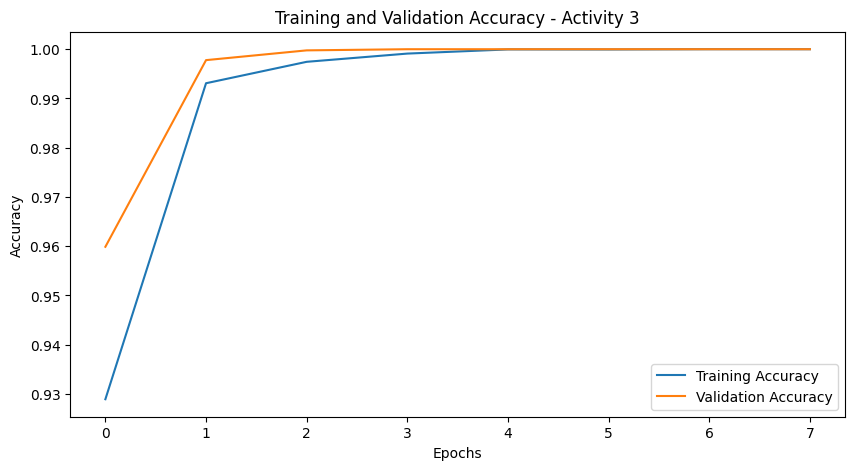

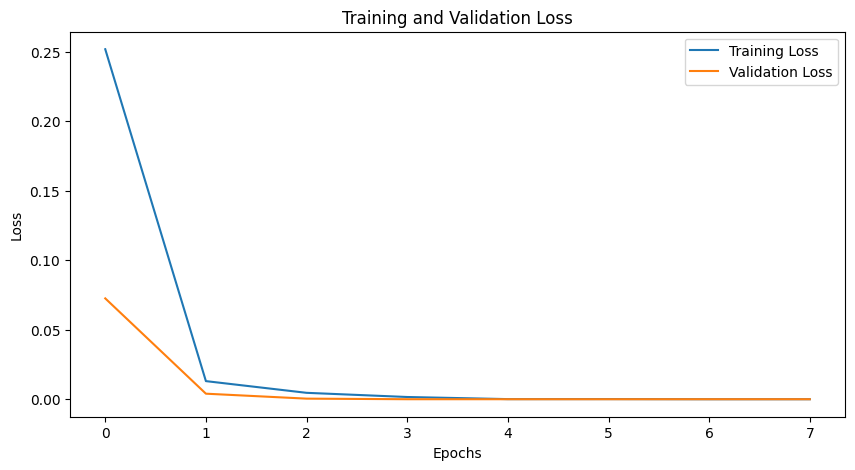

No data leakage detected.
Epoch 1/8
3772/3772 [==============================] - 19s 4ms/step - loss: 0.2887 - accuracy: 0.9921 - val_loss: 0.1403 - val_accuracy: 1.0000
Epoch 2/8
3772/3772 [==============================] - 18s 5ms/step - loss: 0.0760 - accuracy: 0.9999 - val_loss: 0.0311 - val_accuracy: 1.0000
Epoch 3/8
3772/3772 [==============================] - 16s 4ms/step - loss: 0.0235 - accuracy: 1.0000 - val_loss: 0.0151 - val_accuracy: 1.0000
Epoch 4/8
3772/3772 [==============================] - 16s 4ms/step - loss: 0.0070 - accuracy: 1.0000 - val_loss: 1.6317e-04 - val_accuracy: 1.0000
Epoch 5/8
3772/3772 [==============================] - 19s 5ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 5.9629e-07 - val_accuracy: 1.0000
Epoch 6/8
3772/3772 [==============================] - 16s 4ms/step - loss: 2.7106e-04 - accuracy: 1.0000 - val_loss: 5.9607e-07 - val_accuracy: 1.0000
Epoch 7/8
3772/3772 [==============================] - 17s 4ms/step - loss: 2.2360e-04 - accur

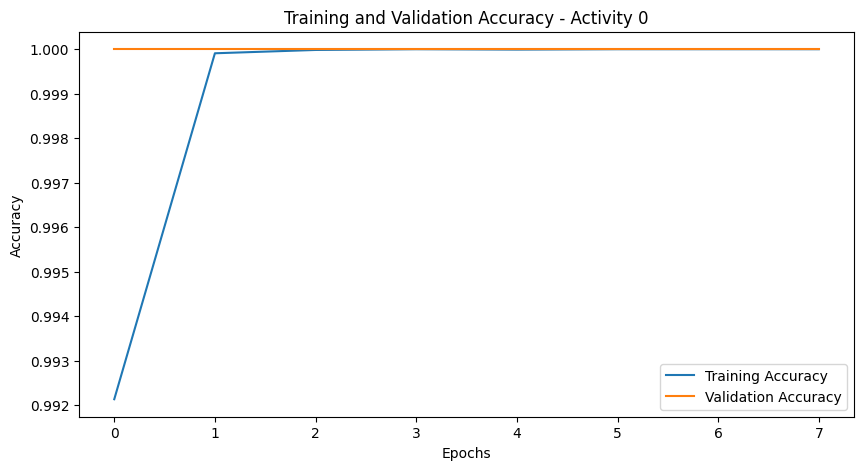

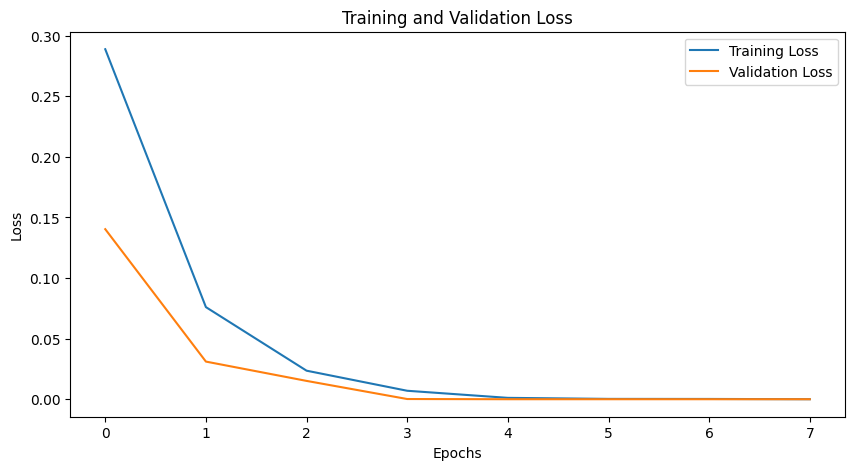

Epoch 1/8
3789/3789 [==============================] - 20s 5ms/step - loss: 0.3224 - accuracy: 0.8581 - val_loss: 0.0520 - val_accuracy: 0.9770
Epoch 2/8
3789/3789 [==============================] - 17s 4ms/step - loss: 0.0176 - accuracy: 0.9907 - val_loss: 0.0085 - val_accuracy: 0.9956
Epoch 3/8
3789/3789 [==============================] - 16s 4ms/step - loss: 0.0050 - accuracy: 0.9973 - val_loss: 0.0073 - val_accuracy: 0.9959
Epoch 4/8
3789/3789 [==============================] - 17s 4ms/step - loss: 0.0039 - accuracy: 0.9980 - val_loss: 0.0055 - val_accuracy: 0.9969
Epoch 5/8
3789/3789 [==============================] - 19s 5ms/step - loss: 0.0053 - accuracy: 0.9971 - val_loss: 0.0014 - val_accuracy: 0.9992
Epoch 6/8
3789/3789 [==============================] - 16s 4ms/step - loss: 0.0030 - accuracy: 0.9983 - val_loss: 0.0016 - val_accuracy: 0.9991
Epoch 7/8
3789/3789 [==============================] - 17s 4ms/step - loss: 0.0037 - accuracy: 0.9980 - val_loss: 3.1312e-04 - val_accur

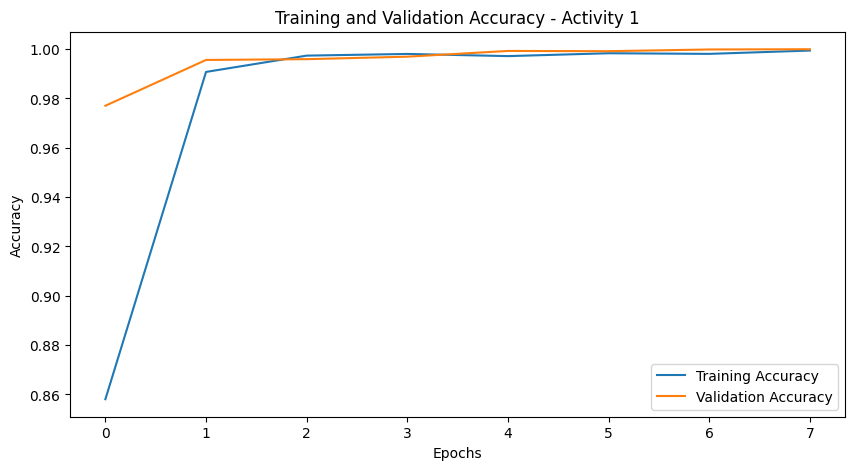

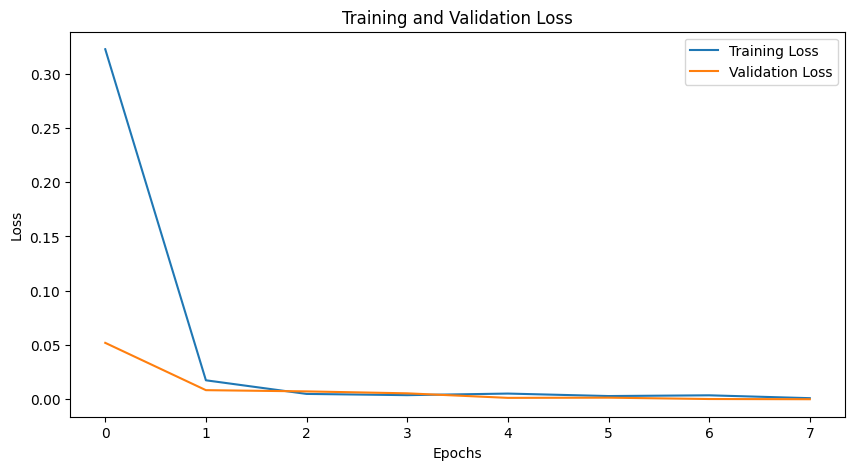

Epoch 1/8
3703/3703 [==============================] - 18s 4ms/step - loss: 0.1187 - accuracy: 0.9820 - val_loss: 0.0016 - val_accuracy: 0.9992
Epoch 2/8
3703/3703 [==============================] - 17s 5ms/step - loss: 0.0068 - accuracy: 0.9965 - val_loss: 8.8879e-04 - val_accuracy: 0.9995
Epoch 3/8
3703/3703 [==============================] - 15s 4ms/step - loss: 0.0030 - accuracy: 0.9985 - val_loss: 3.4972e-04 - val_accuracy: 0.9998
Epoch 4/8
3703/3703 [==============================] - 16s 4ms/step - loss: 0.0014 - accuracy: 0.9992 - val_loss: 1.7517e-04 - val_accuracy: 0.9999
Epoch 5/8
3703/3703 [==============================] - 16s 4ms/step - loss: 0.0013 - accuracy: 0.9993 - val_loss: 6.1093e-07 - val_accuracy: 1.0000
Epoch 6/8
3703/3703 [==============================] - 18s 5ms/step - loss: 7.9768e-05 - accuracy: 1.0000 - val_loss: 5.9605e-07 - val_accuracy: 1.0000
Epoch 7/8
3703/3703 [==============================] - 20s 5ms/step - loss: 1.0499e-06 - accuracy: 1.0000 - val_

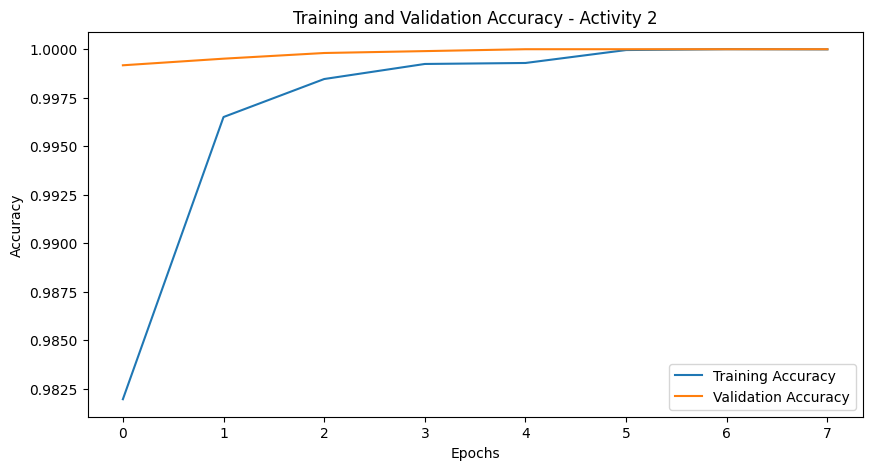

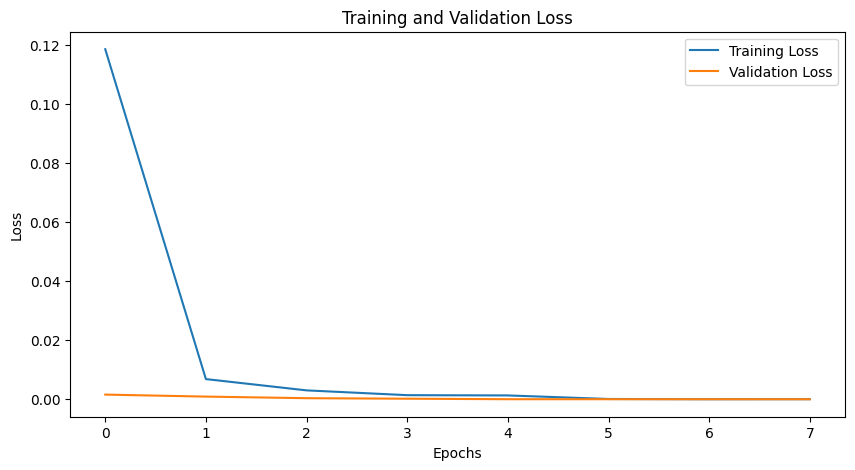

Epoch 1/8
4633/4633 [==============================] - 23s 4ms/step - loss: 0.1131 - accuracy: 0.9822 - val_loss: 0.0026 - val_accuracy: 0.9986
Epoch 2/8
4633/4633 [==============================] - 22s 5ms/step - loss: 0.0508 - accuracy: 0.9727 - val_loss: 0.2542 - val_accuracy: 0.8581
Epoch 3/8
4633/4633 [==============================] - 22s 5ms/step - loss: 0.0086 - accuracy: 0.9952 - val_loss: 0.0035 - val_accuracy: 0.9980
Epoch 4/8
4633/4633 [==============================] - 24s 5ms/step - loss: 0.0035 - accuracy: 0.9980 - val_loss: 7.0516e-04 - val_accuracy: 0.9996
Epoch 5/8
4633/4633 [==============================] - 20s 4ms/step - loss: 0.0022 - accuracy: 0.9989 - val_loss: 0.0026 - val_accuracy: 0.9991
Epoch 6/8
4633/4633 [==============================] - 20s 4ms/step - loss: 8.2911e-04 - accuracy: 0.9995 - val_loss: 0.0010 - val_accuracy: 0.9997
Epoch 7/8
4633/4633 [==============================] - 22s 5ms/step - loss: 4.3668e-04 - accuracy: 0.9998 - val_loss: 1.2858e-04

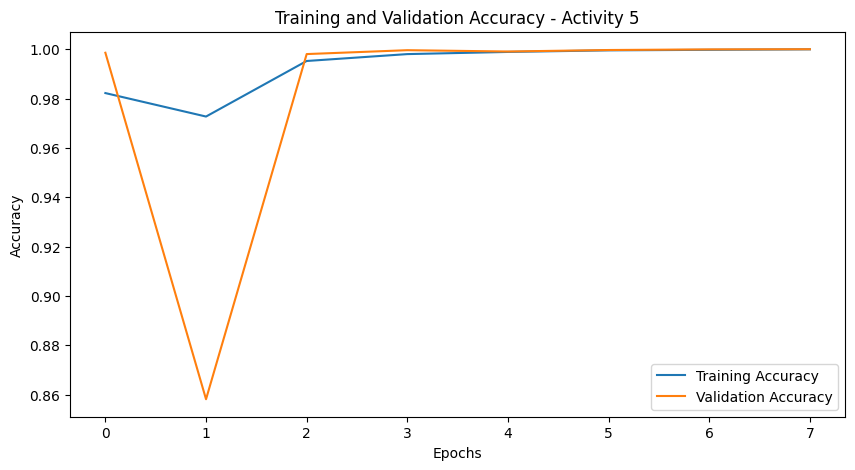

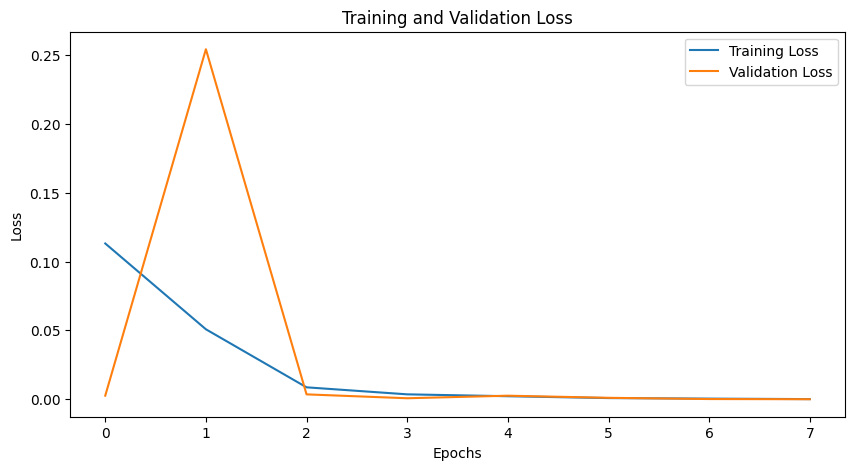

Epoch 1/8
3412/3412 [==============================] - 16s 4ms/step - loss: 0.1421 - accuracy: 0.9762 - val_loss: 8.8740e-05 - val_accuracy: 1.0000
Epoch 2/8
3412/3412 [==============================] - 15s 4ms/step - loss: 0.0815 - accuracy: 0.9555 - val_loss: 0.0019 - val_accuracy: 0.9990
Epoch 3/8
3412/3412 [==============================] - 14s 4ms/step - loss: 0.0137 - accuracy: 0.9923 - val_loss: 1.7694e-04 - val_accuracy: 0.9999
Epoch 4/8
3412/3412 [==============================] - 13s 4ms/step - loss: 0.0101 - accuracy: 0.9946 - val_loss: 4.7756e-07 - val_accuracy: 1.0000
Epoch 5/8
3412/3412 [==============================] - 14s 4ms/step - loss: 0.0050 - accuracy: 0.9973 - val_loss: 4.7703e-07 - val_accuracy: 1.0000
Epoch 6/8
3412/3412 [==============================] - 16s 5ms/step - loss: 7.9979e-04 - accuracy: 0.9996 - val_loss: 4.7690e-07 - val_accuracy: 1.0000
Epoch 7/8
3412/3412 [==============================] - 14s 4ms/step - loss: 3.9601e-04 - accuracy: 0.9998 - val_

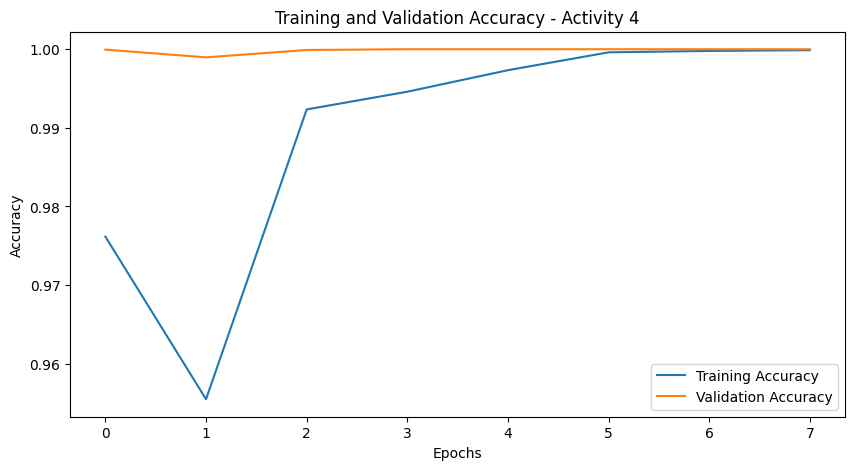

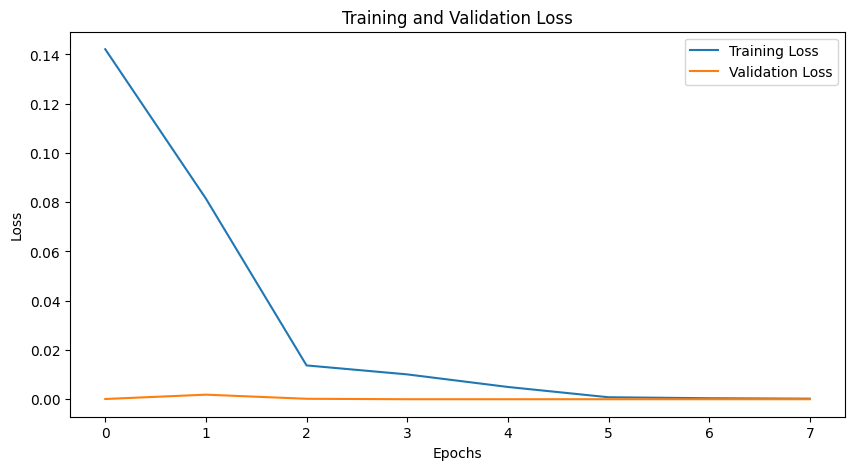

Epoch 1/8
4515/4515 [==============================] - 26s 5ms/step - loss: 0.3132 - accuracy: 0.8705 - val_loss: 0.0043 - val_accuracy: 0.9976
Epoch 2/8
4515/4515 [==============================] - 23s 5ms/step - loss: 0.0122 - accuracy: 0.9933 - val_loss: 6.2161e-07 - val_accuracy: 1.0000
Epoch 3/8
4515/4515 [==============================] - 22s 5ms/step - loss: 4.5388e-04 - accuracy: 0.9998 - val_loss: 6.1942e-07 - val_accuracy: 1.0000
Epoch 4/8
4515/4515 [==============================] - 21s 5ms/step - loss: 2.4325e-04 - accuracy: 0.9999 - val_loss: 5.9621e-07 - val_accuracy: 1.0000
Epoch 5/8
4515/4515 [==============================] - 23s 5ms/step - loss: 7.5410e-05 - accuracy: 1.0000 - val_loss: 5.9605e-07 - val_accuracy: 1.0000
Epoch 6/8
4515/4515 [==============================] - 24s 5ms/step - loss: 3.7804e-05 - accuracy: 1.0000 - val_loss: 5.9605e-07 - val_accuracy: 1.0000
Epoch 7/8
4515/4515 [==============================] - 22s 5ms/step - loss: 5.9628e-07 - accuracy: 1

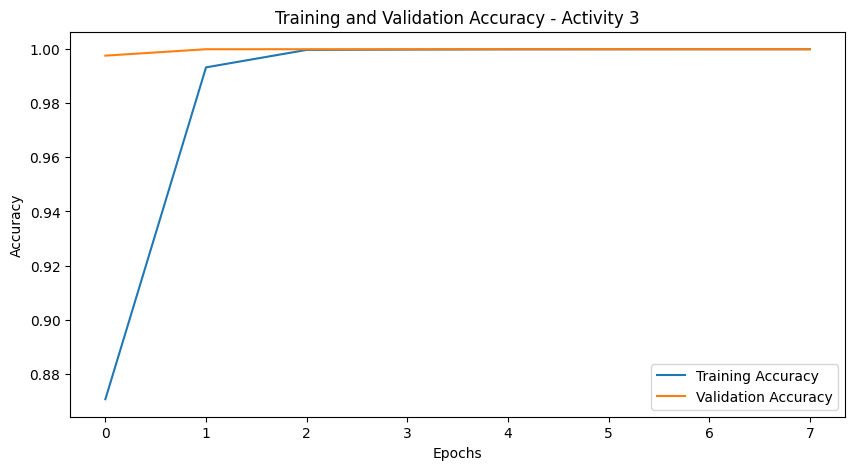

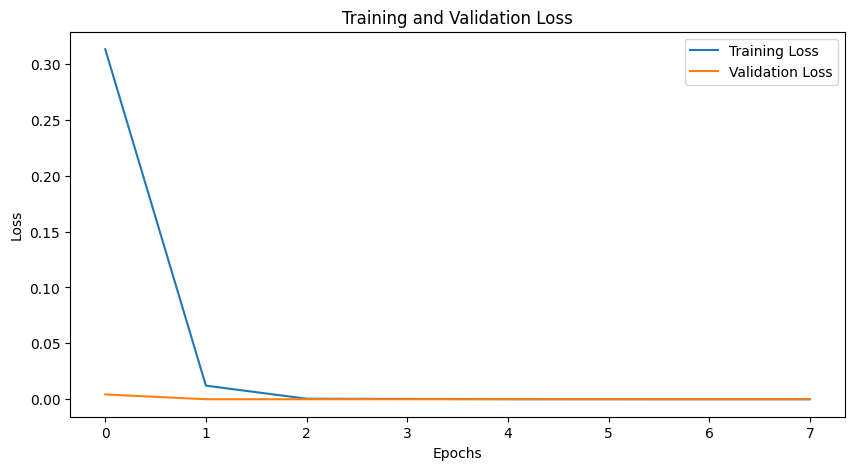

No data leakage detected.
Epoch 1/8
3721/3721 [==============================] - 23s 5ms/step - loss: 0.3564 - accuracy: 0.9886 - val_loss: 0.1582 - val_accuracy: 1.0000
Epoch 2/8
3721/3721 [==============================] - 18s 5ms/step - loss: 0.2121 - accuracy: 0.9999 - val_loss: 0.1498 - val_accuracy: 1.0000
Epoch 3/8
3721/3721 [==============================] - 20s 5ms/step - loss: 0.1302 - accuracy: 1.0000 - val_loss: 0.0220 - val_accuracy: 1.0000
Epoch 4/8
3721/3721 [==============================] - 19s 5ms/step - loss: 0.0194 - accuracy: 1.0000 - val_loss: 5.9801e-07 - val_accuracy: 1.0000
Epoch 5/8
3721/3721 [==============================] - 19s 5ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 5.9740e-07 - val_accuracy: 1.0000
Epoch 6/8
3721/3721 [==============================] - 19s 5ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 5.9806e-07 - val_accuracy: 1.0000
Epoch 7/8
3721/3721 [==============================] - 18s 5ms/step - loss: 0.0021 - accuracy: 1.0

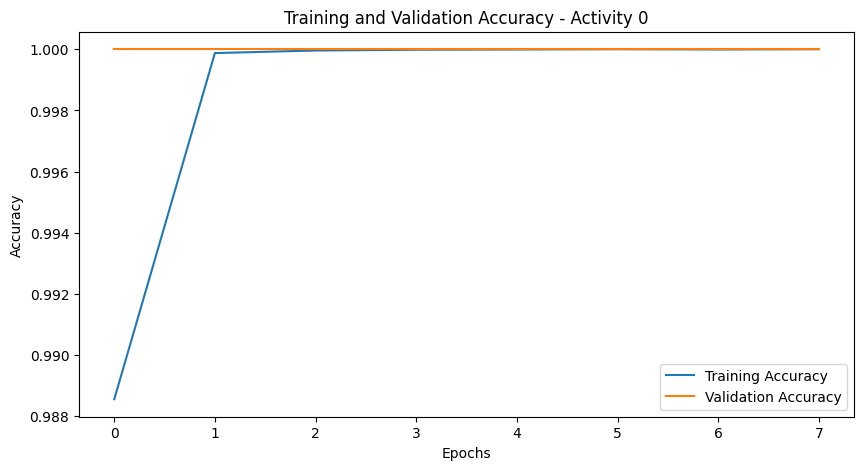

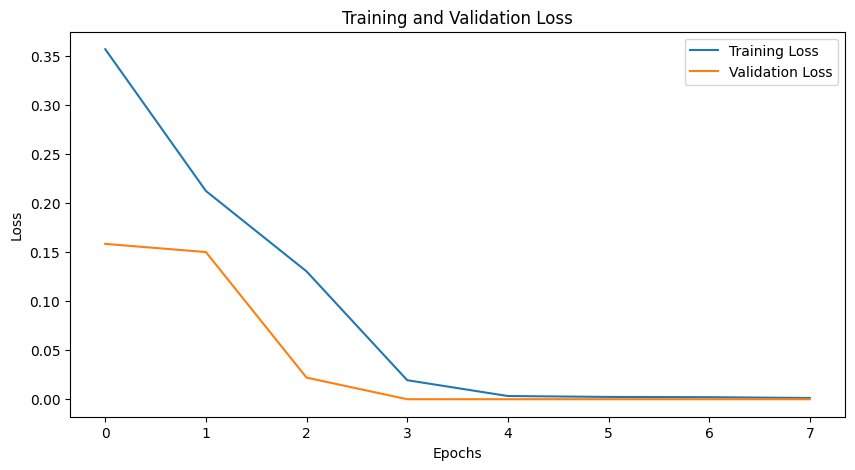

Epoch 1/8
3848/3848 [==============================] - 23s 5ms/step - loss: 0.1814 - accuracy: 0.9346 - val_loss: 0.0029 - val_accuracy: 0.9984
Epoch 2/8
3848/3848 [==============================] - 18s 5ms/step - loss: 0.0232 - accuracy: 0.9874 - val_loss: 0.0029 - val_accuracy: 0.9984
Epoch 3/8
3848/3848 [==============================] - 18s 5ms/step - loss: 0.0016 - accuracy: 0.9992 - val_loss: 6.0228e-07 - val_accuracy: 1.0000
Epoch 4/8
3848/3848 [==============================] - 20s 5ms/step - loss: 5.0085e-04 - accuracy: 0.9997 - val_loss: 5.9622e-07 - val_accuracy: 1.0000
Epoch 5/8
3848/3848 [==============================] - 18s 5ms/step - loss: 1.5354e-04 - accuracy: 0.9999 - val_loss: 5.9605e-07 - val_accuracy: 1.0000
Epoch 6/8
3848/3848 [==============================] - 19s 5ms/step - loss: 3.7708e-06 - accuracy: 1.0000 - val_loss: 5.9605e-07 - val_accuracy: 1.0000
Epoch 7/8
3848/3848 [==============================] - 21s 6ms/step - loss: 5.9608e-07 - accuracy: 1.0000 - 

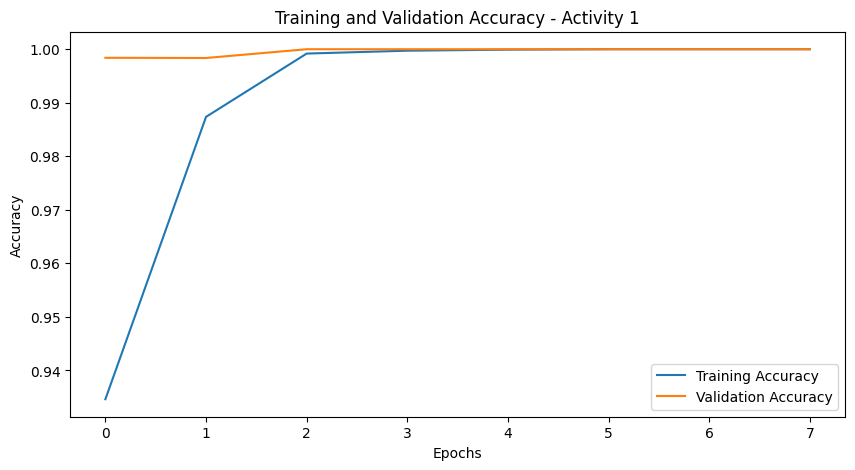

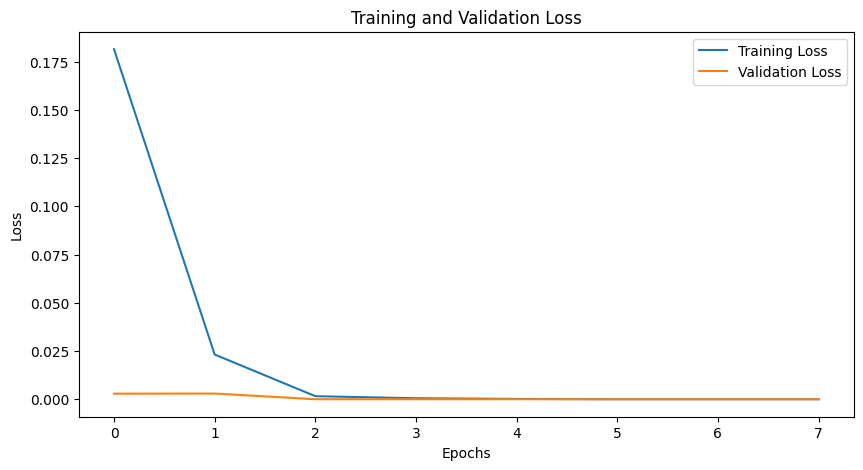

Epoch 1/8
3653/3653 [==============================] - 26s 6ms/step - loss: 0.2207 - accuracy: 0.9209 - val_loss: 0.1408 - val_accuracy: 0.9222
Epoch 2/8
3653/3653 [==============================] - 19s 5ms/step - loss: 0.1131 - accuracy: 0.9376 - val_loss: 0.0031 - val_accuracy: 0.9984
Epoch 3/8
3653/3653 [==============================] - 20s 5ms/step - loss: 0.0280 - accuracy: 0.9846 - val_loss: 6.0966e-07 - val_accuracy: 1.0000
Epoch 4/8
3653/3653 [==============================] - 21s 6ms/step - loss: 0.0059 - accuracy: 0.9968 - val_loss: 5.9933e-07 - val_accuracy: 1.0000
Epoch 5/8
3653/3653 [==============================] - 21s 6ms/step - loss: 0.0015 - accuracy: 0.9992 - val_loss: 5.9702e-07 - val_accuracy: 1.0000
Epoch 6/8
3653/3653 [==============================] - 20s 5ms/step - loss: 0.0011 - accuracy: 0.9994 - val_loss: 5.9937e-07 - val_accuracy: 1.0000
Epoch 7/8
3653/3653 [==============================] - 24s 6ms/step - loss: 2.6263e-04 - accuracy: 0.9999 - val_loss: 5.

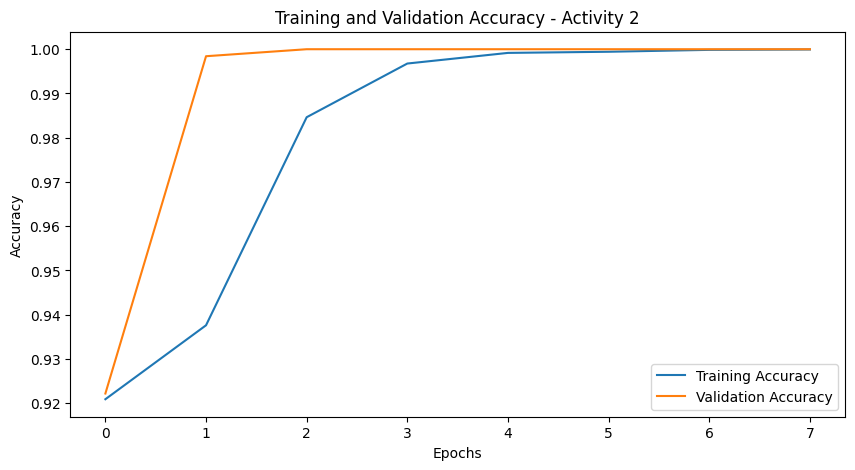

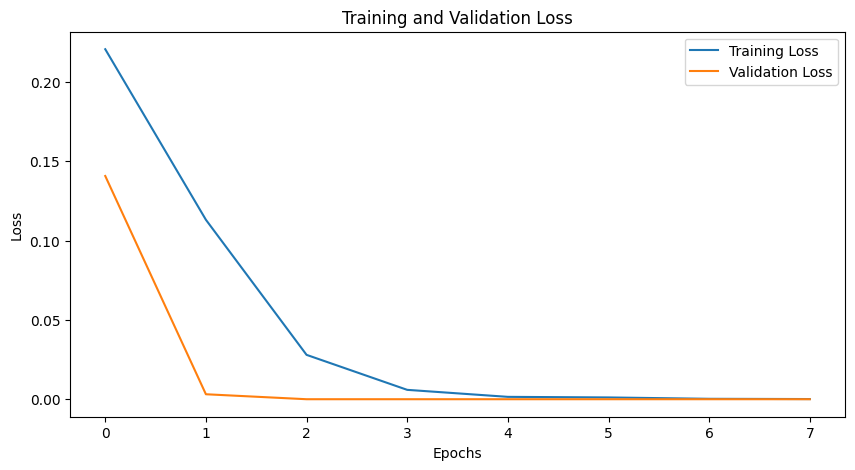

Epoch 1/8
4474/4474 [==============================] - 30s 6ms/step - loss: 0.3797 - accuracy: 0.8291 - val_loss: 0.0031 - val_accuracy: 0.9983
Epoch 2/8
4474/4474 [==============================] - 26s 6ms/step - loss: 0.0207 - accuracy: 0.9885 - val_loss: 5.1655e-07 - val_accuracy: 1.0000
Epoch 3/8
4474/4474 [==============================] - 25s 6ms/step - loss: 0.0059 - accuracy: 0.9968 - val_loss: 5.0295e-07 - val_accuracy: 1.0000
Epoch 4/8
4474/4474 [==============================] - 30s 7ms/step - loss: 0.0026 - accuracy: 0.9986 - val_loss: 4.8702e-07 - val_accuracy: 1.0000
Epoch 5/8
4474/4474 [==============================] - 25s 6ms/step - loss: 3.7447e-04 - accuracy: 0.9998 - val_loss: 4.7769e-07 - val_accuracy: 1.0000
Epoch 6/8
4474/4474 [==============================] - 26s 6ms/step - loss: 1.5046e-05 - accuracy: 1.0000 - val_loss: 4.7736e-07 - val_accuracy: 1.0000
Epoch 7/8
4474/4474 [==============================] - 27s 6ms/step - loss: 1.1086e-04 - accuracy: 1.0000 - 

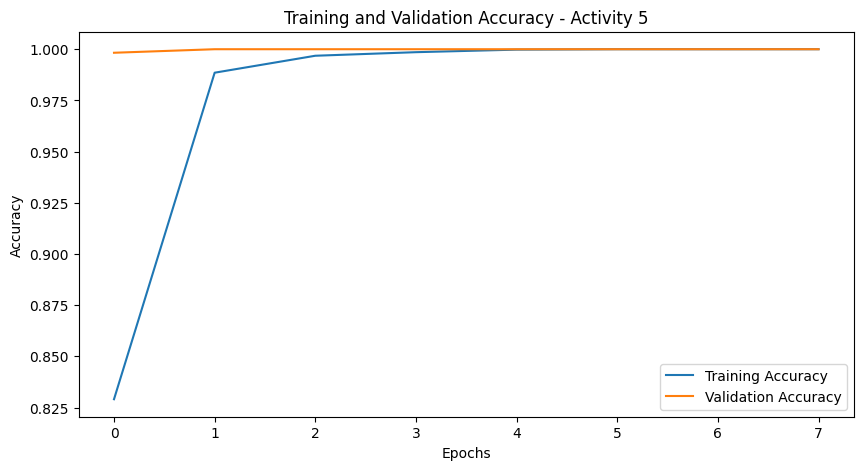

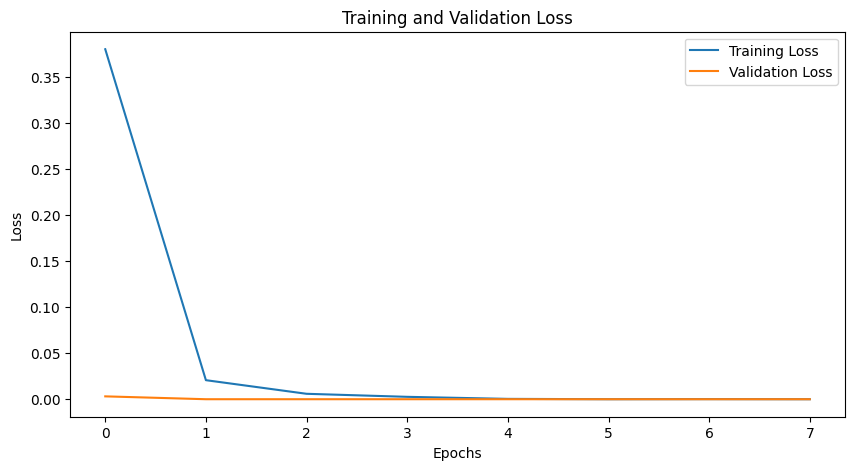

Epoch 1/8
3284/3284 [==============================] - 22s 6ms/step - loss: 0.2343 - accuracy: 0.9339 - val_loss: 0.0692 - val_accuracy: 0.9620
Epoch 2/8
3284/3284 [==============================] - 19s 6ms/step - loss: 0.0141 - accuracy: 0.9926 - val_loss: 0.0185 - val_accuracy: 0.9897
Epoch 3/8
3284/3284 [==============================] - 20s 6ms/step - loss: 0.0021 - accuracy: 0.9990 - val_loss: 7.3968e-05 - val_accuracy: 1.0000
Epoch 4/8
3284/3284 [==============================] - 20s 6ms/step - loss: 7.4857e-04 - accuracy: 0.9996 - val_loss: 7.3919e-05 - val_accuracy: 1.0000
Epoch 5/8
3284/3284 [==============================] - 19s 6ms/step - loss: 3.3580e-04 - accuracy: 0.9998 - val_loss: 0.0011 - val_accuracy: 0.9994
Epoch 6/8
3284/3284 [==============================] - 20s 6ms/step - loss: 2.9558e-04 - accuracy: 0.9998 - val_loss: 4.8329e-07 - val_accuracy: 1.0000
Epoch 7/8
3284/3284 [==============================] - 18s 5ms/step - loss: 1.3153e-04 - accuracy: 0.9999 - val_

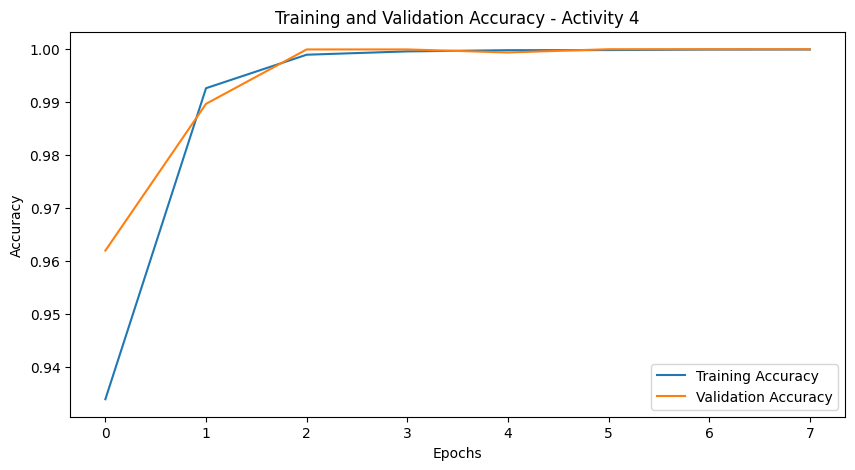

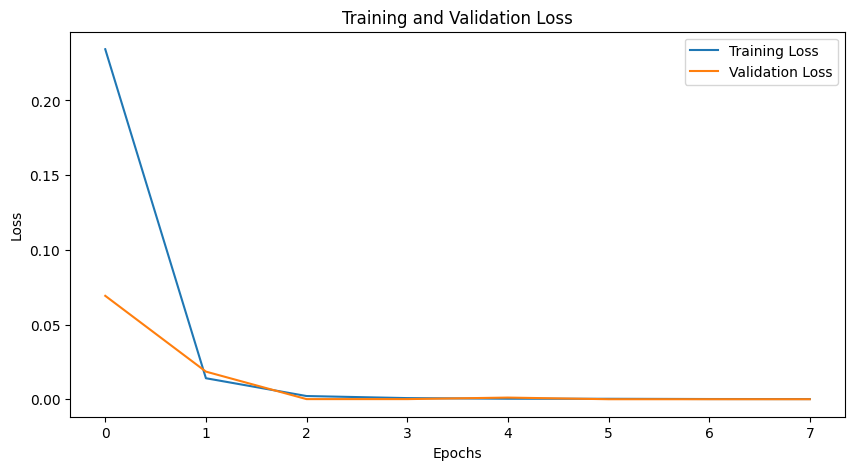

Epoch 1/8
4422/4422 [==============================] - 29s 6ms/step - loss: 0.1579 - accuracy: 0.9621 - val_loss: 1.6848e-04 - val_accuracy: 0.9999
Epoch 2/8
4422/4422 [==============================] - 30s 7ms/step - loss: 0.0097 - accuracy: 0.9948 - val_loss: 7.2042e-07 - val_accuracy: 1.0000
Epoch 3/8
4422/4422 [==============================] - 25s 6ms/step - loss: 0.0035 - accuracy: 0.9981 - val_loss: 6.4910e-07 - val_accuracy: 1.0000
Epoch 4/8
4422/4422 [==============================] - 27s 6ms/step - loss: 0.0013 - accuracy: 0.9993 - val_loss: 6.3647e-07 - val_accuracy: 1.0000
Epoch 5/8
4422/4422 [==============================] - 26s 6ms/step - loss: 5.1335e-04 - accuracy: 0.9998 - val_loss: 5.9662e-07 - val_accuracy: 1.0000
Epoch 6/8
4422/4422 [==============================] - 22s 5ms/step - loss: 7.7146e-04 - accuracy: 0.9996 - val_loss: 3.3622e-04 - val_accuracy: 0.9998
Epoch 7/8
4422/4422 [==============================] - 25s 6ms/step - loss: 5.0030e-04 - accuracy: 0.999

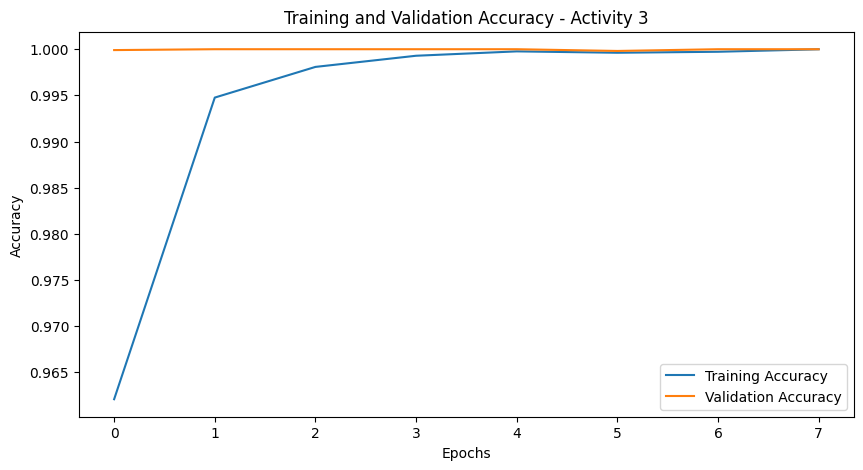

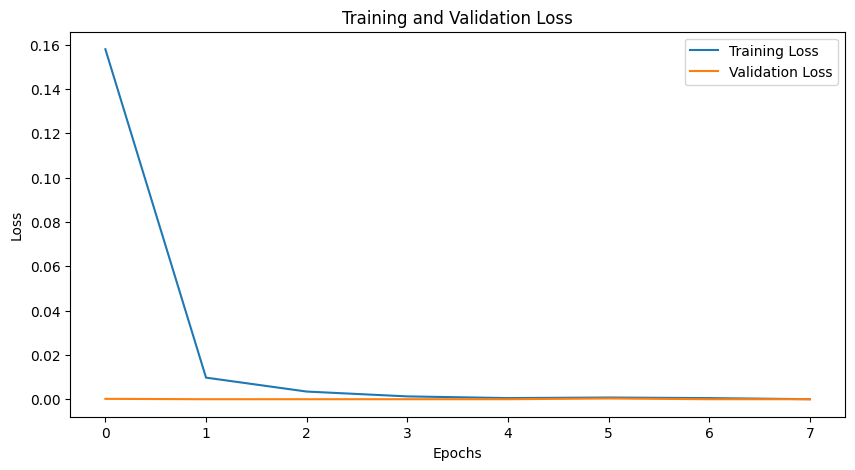

No data leakage detected.
Epoch 1/8
3741/3741 [==============================] - 26s 6ms/step - loss: 0.2488 - accuracy: 0.9810 - val_loss: 9.1034e-04 - val_accuracy: 1.0000
Epoch 2/8
3741/3741 [==============================] - 21s 6ms/step - loss: 0.0101 - accuracy: 0.9999 - val_loss: 5.4584e-04 - val_accuracy: 1.0000
Epoch 3/8
3741/3741 [==============================] - 21s 6ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 4.6707e-04 - val_accuracy: 1.0000
Epoch 4/8
3741/3741 [==============================] - 21s 6ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 5.9726e-07 - val_accuracy: 1.0000
Epoch 5/8
3741/3741 [==============================] - 21s 6ms/step - loss: 8.3042e-04 - accuracy: 1.0000 - val_loss: 5.9943e-07 - val_accuracy: 1.0000
Epoch 6/8
3741/3741 [==============================] - 22s 6ms/step - loss: 4.8987e-04 - accuracy: 1.0000 - val_loss: 5.9773e-07 - val_accuracy: 1.0000
Epoch 7/8
3741/3741 [==============================] - 22s 6ms/step - loss: 1.

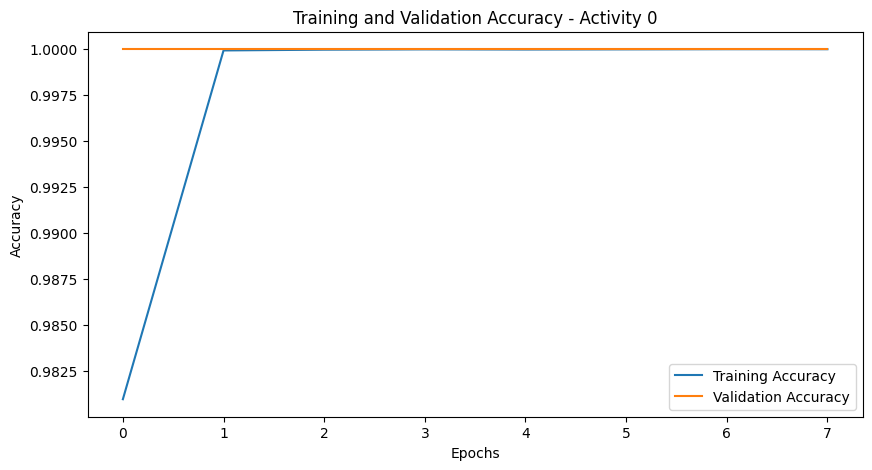

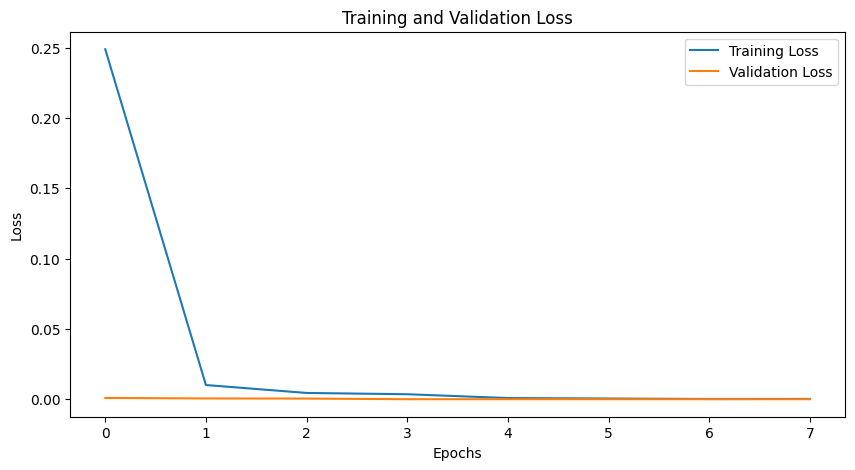

Epoch 1/8
3891/3891 [==============================] - 25s 6ms/step - loss: 0.2199 - accuracy: 0.9388 - val_loss: 0.0605 - val_accuracy: 0.9663
Epoch 2/8
3891/3891 [==============================] - 24s 6ms/step - loss: 0.0134 - accuracy: 0.9932 - val_loss: 0.0284 - val_accuracy: 0.9842
Epoch 3/8
3891/3891 [==============================] - 24s 6ms/step - loss: 0.0023 - accuracy: 0.9988 - val_loss: 0.0059 - val_accuracy: 0.9967
Epoch 4/8
3891/3891 [==============================] - 24s 6ms/step - loss: 0.0046 - accuracy: 0.9976 - val_loss: 0.0058 - val_accuracy: 0.9967
Epoch 5/8
3891/3891 [==============================] - 23s 6ms/step - loss: 0.0029 - accuracy: 0.9984 - val_loss: 0.0032 - val_accuracy: 0.9982
Epoch 6/8
3891/3891 [==============================] - 22s 6ms/step - loss: 8.3866e-04 - accuracy: 0.9995 - val_loss: 6.0222e-07 - val_accuracy: 1.0000
Epoch 7/8
3891/3891 [==============================] - 24s 6ms/step - loss: 1.9277e-04 - accuracy: 0.9999 - val_loss: 5.9747e-07

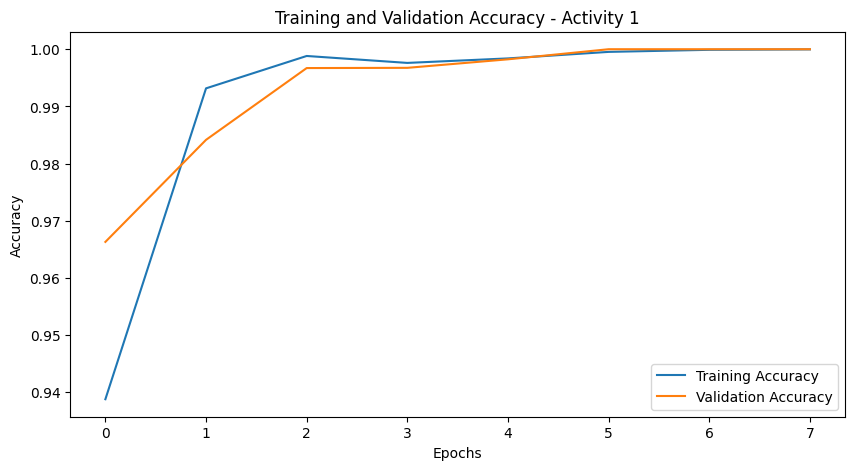

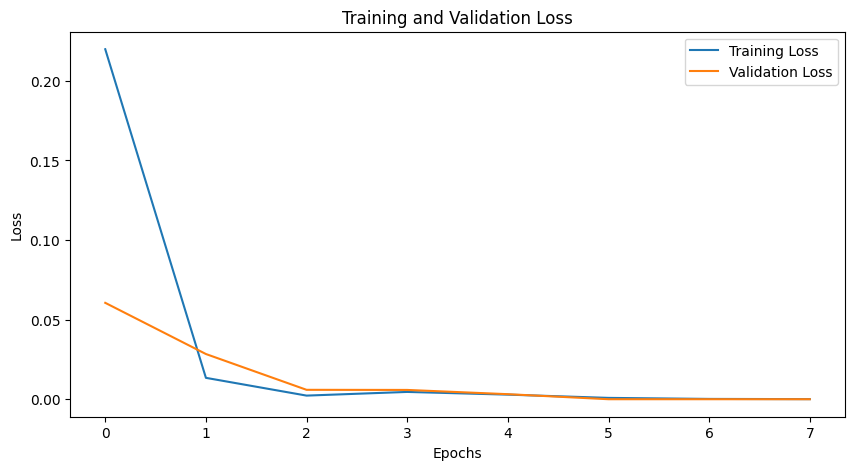

Epoch 1/8
3573/3573 [==============================] - 28s 7ms/step - loss: 0.2168 - accuracy: 0.9272 - val_loss: 3.6345e-04 - val_accuracy: 0.9998
Epoch 2/8
3573/3573 [==============================] - 22s 6ms/step - loss: 0.0271 - accuracy: 0.9854 - val_loss: 1.4565e-04 - val_accuracy: 0.9999
Epoch 3/8
3573/3573 [==============================] - 23s 6ms/step - loss: 0.0110 - accuracy: 0.9940 - val_loss: 5.9837e-07 - val_accuracy: 1.0000
Epoch 4/8
3573/3573 [==============================] - 24s 7ms/step - loss: 0.0012 - accuracy: 0.9994 - val_loss: 5.9659e-07 - val_accuracy: 1.0000
Epoch 5/8
3573/3573 [==============================] - 24s 7ms/step - loss: 0.0024 - accuracy: 0.9988 - val_loss: 5.9605e-07 - val_accuracy: 1.0000
Epoch 6/8
3573/3573 [==============================] - 21s 6ms/step - loss: 3.7328e-04 - accuracy: 0.9998 - val_loss: 5.9605e-07 - val_accuracy: 1.0000
Epoch 7/8
3573/3573 [==============================] - 22s 6ms/step - loss: 3.5846e-05 - accuracy: 1.0000 - 

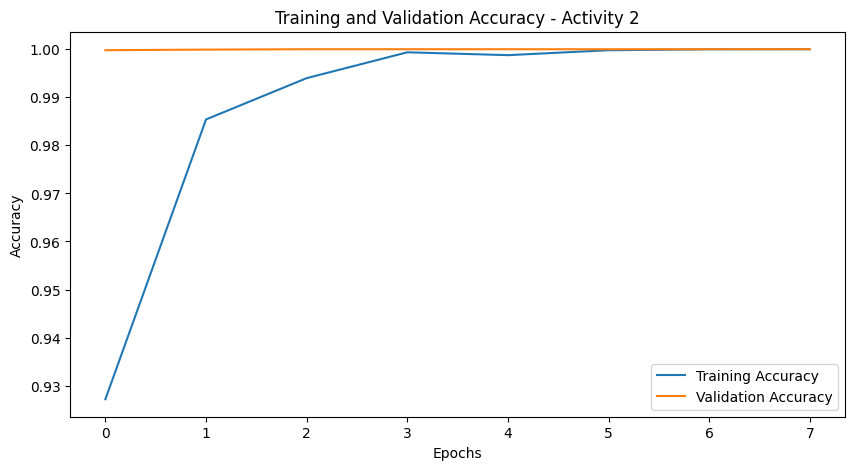

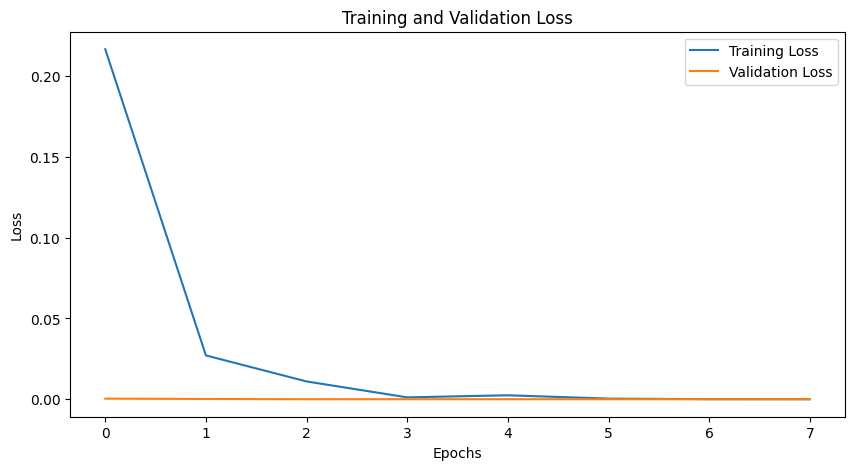

Epoch 1/8
4726/4726 [==============================] - 30s 6ms/step - loss: 0.0594 - accuracy: 0.9899 - val_loss: 3.3085e-06 - val_accuracy: 1.0000
Epoch 2/8
4726/4726 [==============================] - 31s 7ms/step - loss: 0.0014 - accuracy: 0.9993 - val_loss: 5.1716e-07 - val_accuracy: 1.0000
Epoch 3/8
4726/4726 [==============================] - 32s 7ms/step - loss: 5.7460e-04 - accuracy: 0.9997 - val_loss: 5.0927e-07 - val_accuracy: 1.0000
Epoch 4/8
4726/4726 [==============================] - 32s 7ms/step - loss: 4.7103e-04 - accuracy: 0.9998 - val_loss: 4.7696e-07 - val_accuracy: 1.0000
Epoch 5/8
4726/4726 [==============================] - 28s 6ms/step - loss: 6.2544e-05 - accuracy: 1.0000 - val_loss: 4.7684e-07 - val_accuracy: 1.0000
Epoch 6/8
4726/4726 [==============================] - 32s 7ms/step - loss: 1.2653e-04 - accuracy: 1.0000 - val_loss: 4.7684e-07 - val_accuracy: 1.0000
Epoch 7/8
4726/4726 [==============================] - 31s 6ms/step - loss: 7.9190e-07 - accurac

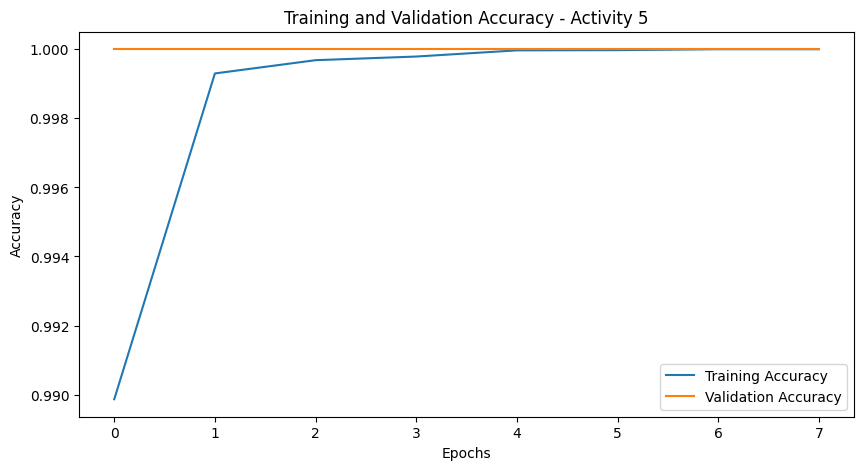

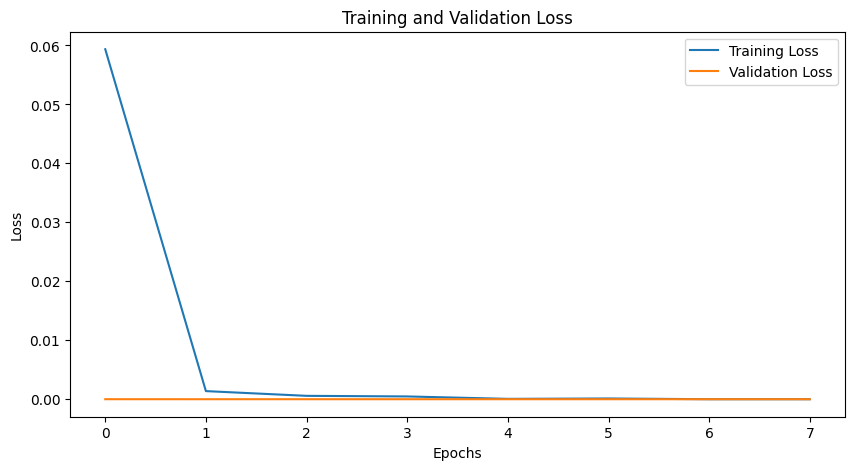

Epoch 1/8
3421/3421 [==============================] - 23s 6ms/step - loss: 0.2906 - accuracy: 0.9016 - val_loss: 0.1340 - val_accuracy: 0.9252
Epoch 2/8
3421/3421 [==============================] - 20s 6ms/step - loss: 0.0312 - accuracy: 0.9828 - val_loss: 0.0027 - val_accuracy: 0.9985
Epoch 3/8
3421/3421 [==============================] - 20s 6ms/step - loss: 0.0086 - accuracy: 0.9954 - val_loss: 0.0031 - val_accuracy: 0.9983
Epoch 4/8
3421/3421 [==============================] - 19s 6ms/step - loss: 0.0042 - accuracy: 0.9977 - val_loss: 8.0529e-04 - val_accuracy: 0.9996
Epoch 5/8
3421/3421 [==============================] - 18s 5ms/step - loss: 0.0028 - accuracy: 0.9985 - val_loss: 8.9472e-04 - val_accuracy: 0.9995
Epoch 6/8
3421/3421 [==============================] - 16s 5ms/step - loss: 0.0045 - accuracy: 0.9975 - val_loss: 4.4760e-04 - val_accuracy: 0.9998
Epoch 7/8
3421/3421 [==============================] - 17s 5ms/step - loss: 0.0014 - accuracy: 0.9992 - val_loss: 4.8023e-07

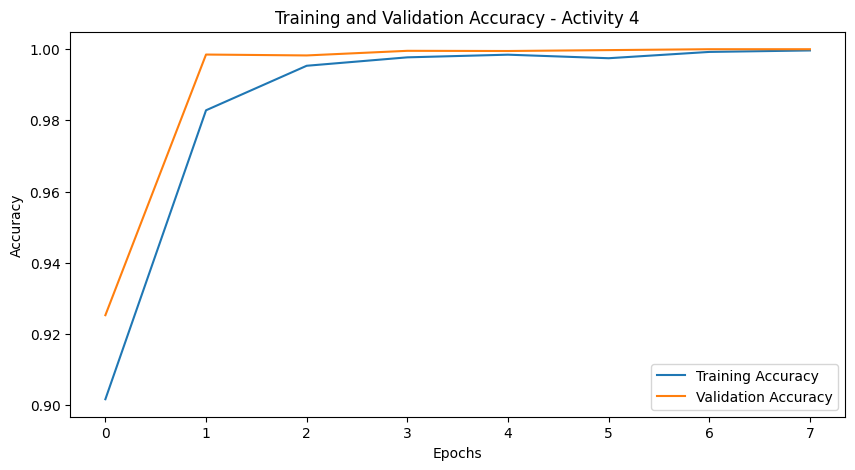

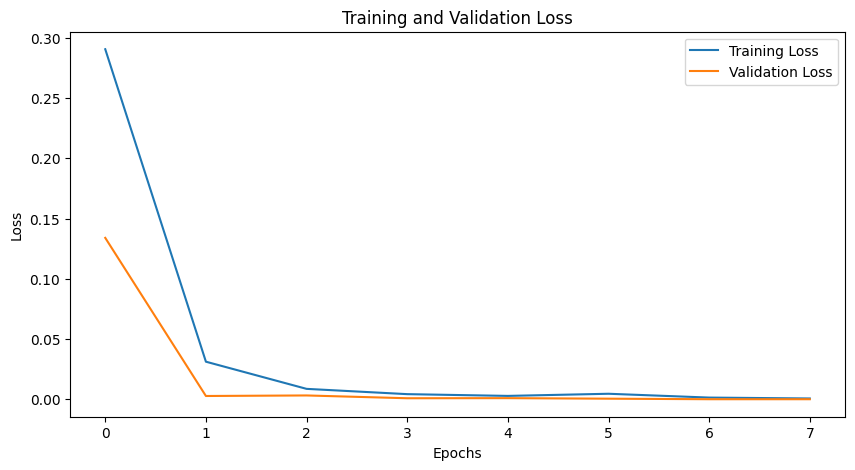

Epoch 1/8
4425/4425 [==============================] - 24s 5ms/step - loss: 0.7548 - accuracy: 0.7330 - val_loss: 0.3680 - val_accuracy: 0.7947
Epoch 2/8
4425/4425 [==============================] - 21s 5ms/step - loss: 0.1948 - accuracy: 0.8925 - val_loss: 0.2333 - val_accuracy: 0.8698
Epoch 3/8
4425/4425 [==============================] - 22s 5ms/step - loss: 0.1192 - accuracy: 0.9341 - val_loss: 0.1651 - val_accuracy: 0.9079
Epoch 4/8
4425/4425 [==============================] - 23s 5ms/step - loss: 0.0148 - accuracy: 0.9918 - val_loss: 0.0577 - val_accuracy: 0.9678
Epoch 5/8
4425/4425 [==============================] - 24s 5ms/step - loss: 0.0052 - accuracy: 0.9972 - val_loss: 9.5466e-04 - val_accuracy: 0.9995
Epoch 6/8
4425/4425 [==============================] - 23s 5ms/step - loss: 1.7780e-04 - accuracy: 0.9999 - val_loss: 1.1290e-04 - val_accuracy: 0.9999
Epoch 7/8
4425/4425 [==============================] - 23s 5ms/step - loss: 1.1691e-04 - accuracy: 0.9999 - val_loss: 6.7975

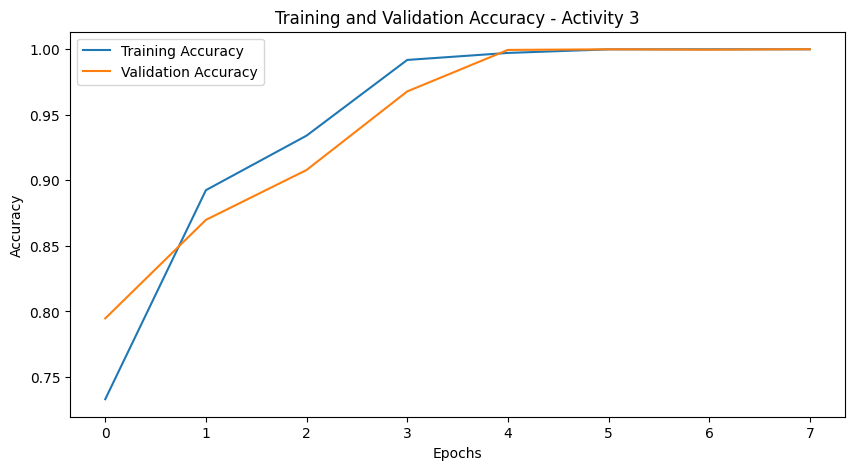

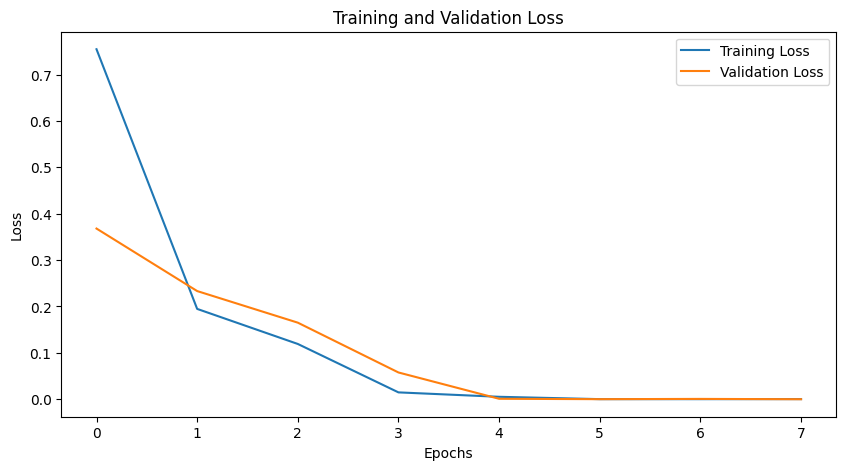

In [25]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)

results = {}

np.random.seed(42)
tf.random.set_seed(24)

activities = data['activityID'].unique()
subjects = data['subject_id'].unique()

scaler = StandardScaler()

num_classes = len(data['activityID'].unique())

for train_index, test_index in kf.split(subjects):
    train_subjects = subjects[train_index]
    test_subjects = subjects[test_index]

    train_data = data[data['subject_id'].isin(train_subjects)]
    test_data = data[data['subject_id'].isin(test_subjects)]

    train_data_ids = set(train_data['subject_id'])
    test_data_ids = set(test_data['subject_id'])

    intersection = train_data_ids.intersection(test_data_ids)
    if intersection:
        print(f"Intersection between train and test data: {intersection}")
    else:
        print("No data leakage detected.")

    for activity in activities:
        train_activity_data = train_data[train_data['activityID'] == activity]
        test_activity_data = test_data[test_data['activityID'] == activity]

        X_train = train_activity_data[feature_columns].values
        y_train = train_activity_data[label_column].values
        X_test = test_activity_data[feature_columns].values
        y_test = test_activity_data[label_column].values

        scaler.fit(X_train)

        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
        X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

        model = Sequential()

        #model.add(LSTM(units=64, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
        model.add(GRU(units=64, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
        model.add(Dropout(0.2))
        model.add(Dense(units=num_classes, activation='relu'))

        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        history = model.fit(X_train_scaled, y_train, epochs=8, batch_size=32, validation_data=(X_test_scaled, y_test))

        #loss, accuracy = model.evaluate(X_test_scaled, y_test)

        #for idx in range(len(X_test)):
          #sample = X_test_scaled[idx].reshape(1, X_test_scaled.shape[1], X_test_scaled.shape[2])
          #true_label = y_test[idx]
          #predicted_probs = model.predict(sample)[0]
          #predicted_label = np.argmax(predicted_probs)

          #if true_label != predicted_label:
             # print(f"Sample {idx}: True Activity: {true_label}, Predicted Activity: {predicted_label}")
          #else:
          #    print(f"Sample {idx} Predicted RIGHT!")

        plt.figure(figsize=(10, 5))
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'Training and Validation Accuracy - Activity {activity}')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

        plt.figure(figsize=(10, 5))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        results[f"Activity_{activity}"] = {'Loss': history.history['loss'], 'Accuracy': history.history['accuracy']}


In [26]:
separate_test_data = data_to_test

X_separate_test = separate_test_data[feature_columns].values
y_separate_test = separate_test_data[label_column].values

X_separate_test_scaled = scaler.transform(X_separate_test)
X_separate_test_scaled = X_separate_test_scaled.reshape(X_separate_test_scaled.shape[0], 1, X_separate_test_scaled.shape[1])

separate_test_loss, separate_test_accuracy = model.evaluate(X_separate_test_scaled, y_separate_test)

print(f"Separate Test Set - Loss: {separate_test_loss}, Accuracy: {separate_test_accuracy}")

9672/9672 [==============================] - 21s 2ms/step - loss: 12.6941 - accuracy: 0.2107
Separate Test Set - Loss: 12.694096565246582, Accuracy: 0.2107354998588562


In [ ]:

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title(f'Training and Validation Accuracy - Activity {activity}')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
results_df = pd.DataFrame(results).T

results_df.to_csv('/content/drive/MyDrive/ColabData/results.csv')